# Krypton Lifetime maps

### Author:  JMH, JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Wed May 29 10:20:29 2019


### Logger

In [2]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2019-05-29 10:20:29,654 | INFO : Hello world!


### Input files

In [3]:
from krcal.core.kr_types import KrFileName

run_number = 7005
num_files = 2815

# run_number = 7023 # for testing
# num_files = 2057 # for testing

if num_files > 7729:
    num_xy_bins = 100
else:
    num_xy_bins = 50

t_start = time.time()

lifetime_limits = (2350, 6100)
e0_limits = (7000, 14000)
e0_limits_rphi = (12000, 14000)

input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
output_plots = f"$IC_DATA/plots"
output_plots = os.path.expandvars(f"{output_plots}/")
# summary_outputs = "/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r"+str(run_number)+"/"
map_path    = f"$IC_DATA/maps"

# Find the name of the correct input dst

dst_directory = os.path.expandvars(f"{input_path}/")
dirlist = os.listdir(dst_directory)
dst_file = ""
for file_name in dirlist:
    try:
        check_number = file_name
        check_number = check_number[check_number.find('_')+1:]
        check_number = check_number[:check_number.find('_')]
        if check_number == str(run_number):
            print('Found the dst:',file_name)
            dst_file = file_name
    except:
        pass

if dst_file == "":
    raise ValueError("Unable to find appropriate dst for run "+str(run_number))

input_file_names  = [ dst_file ]

    
time_bins = 25
output_file_name  = ' '
extra_tag         = '_resVsRPhi_HalfHalf'
map_file_name     = 'kr_maps_xy_'+str(run_number)+'.h5'
map_file_name_ts  = f'kr_maps_rphi_5_8_ts_{time_bins}_'+str(run_number)+extra_tag+'.h5'
emap_file_name    = 'kr_emap_xy_'+str(num_xy_bins)+'_'+str(num_xy_bins)+'_r_'+str(run_number)+extra_tag+'.h5'

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

Found the dst: dst_7005_trigger1_0000_2814.h5


### Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [8]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [9]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import timeit
from krcal.core.core_functions      import NN
from krcal.core                     import fit_functions_ic as fitf

In [10]:
from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

In [11]:
from krcal.core.stat_functions      import mean_and_std

In [12]:
from krcal.core.ranges_and_bins_functions      import kr_ranges_and_bins

In [13]:
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map

from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [14]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [15]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [16]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [17]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName

In [18]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [19]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average
from krcal.core.map_functions   import add_mapinfo

In [20]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [21]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [22]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [23]:
from krcal.core.selection_functions  import event_map_df
from krcal.core.selection_functions  import select_rphi_sectors_df
from krcal.core.selection_functions  import select_xy_sectors_df
from krcal.core.selection_functions  import get_time_series_df
from krcal.core.fitmap_functions     import time_fcs_df
from krcal.core.fitmap_functions     import fit_fcs_in_rphi_sectors_df
from krcal.core.fitmap_functions     import fit_map_xy_df

In [24]:
from numpy import pi, sqrt

In [25]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [26]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [27]:
log = logging.getLogger()

### Input/output 

In [28]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [29]:
t0 = time.time()
dst           = load_dsts(fn.input_file_names, "DST", "Events")
t1 = time.time()
print(f'Read in file time: t = {t1 -t0}')

Read in file time: t = 2.6604137420654297


In [30]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 552211


In [31]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [32]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [33]:
RMAX      = 180
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 7000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = num_xy_bins,
                                                        ynbins    = num_xy_bins,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [34]:
dstFid = dst[in_range(dst.R, 0, RMAX)]

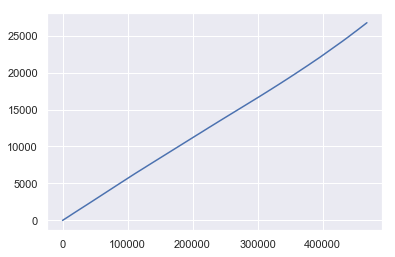

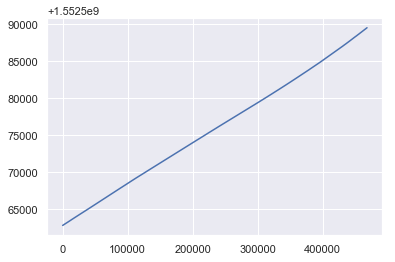

In [35]:
dst_time = dstFid.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
dst = dst_time.assign(DT=DT)
plt.plot(DT)
plt.show()
plt.plot(T)
plt.show()

In [36]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

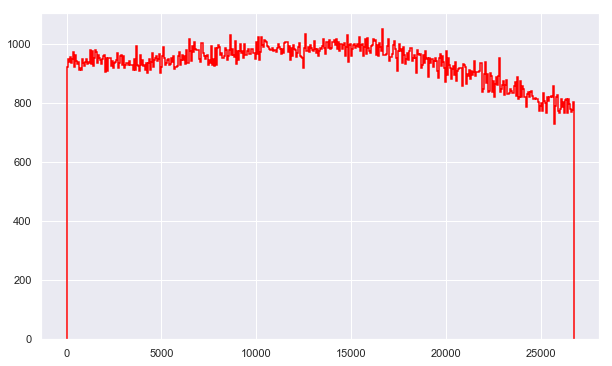

In [37]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

### Time 

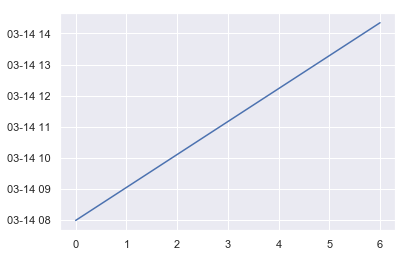

In [38]:
plt.plot(krTimes.timeStamps)

### Event distribution

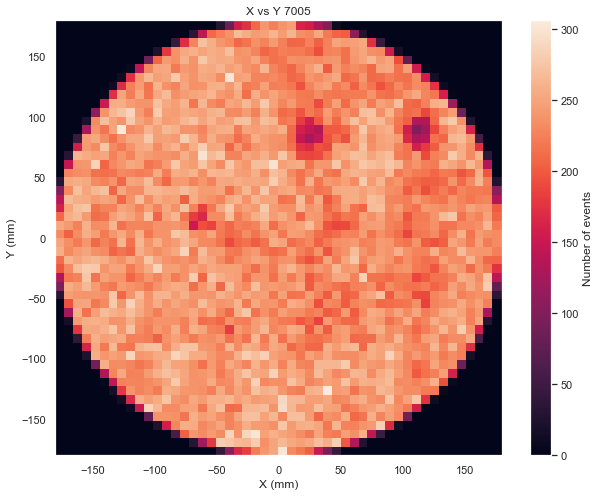

In [39]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y '+str(run_number)),
           profile=False,
           figsize=(10,8))
# plt.savefig(output_plots+'/EventDists/EventDist_'+str(run_number)+'.png')

## Time series

In [40]:
log.setLevel(logging.INFO)

### Divide dst in 100 time series

In [41]:
time_bins = 25
t0 = time.time()

evens = [x % 2 == 0 for x in range(len(dst))]
odds = [x % 2 == 1 for x in range(len(dst))]
dst_even = dst[evens]
dst_odd = dst[odds]
DT_even = DT[evens]
DT_odd = DT[odds]

RFID = 180

dstfid_even = dst_even[in_range(dst_even.R, 0, RFID)]
ts_even, masks_even = get_time_series_df(time_bins, (DT[0],DT[-1]), dstfid_even) # [edit]

dstfid_odd = dst_odd[in_range(dst_odd.R, 0, RFID)]
ts_odd, masks_odd = get_time_series_df(time_bins, (DT[0],DT[-1]), dstfid_odd) # [edit]

t1 = time.time()
print(f' get_time_series: t = {t1 -t0}')

 get_time_series: t = 0.5034759044647217


### Fit lifetime full detector

In [42]:
t0 = time.time()
fps = time_fcs_df(ts_even, masks_even, dstfid_even, 
                 nbins_z = 15,
                 nbins_e = 25,
                 range_z = (10, 550),
                 range_e = (7000, 14000),
                 energy  = 'S2e',
                 fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 0.24472379684448242


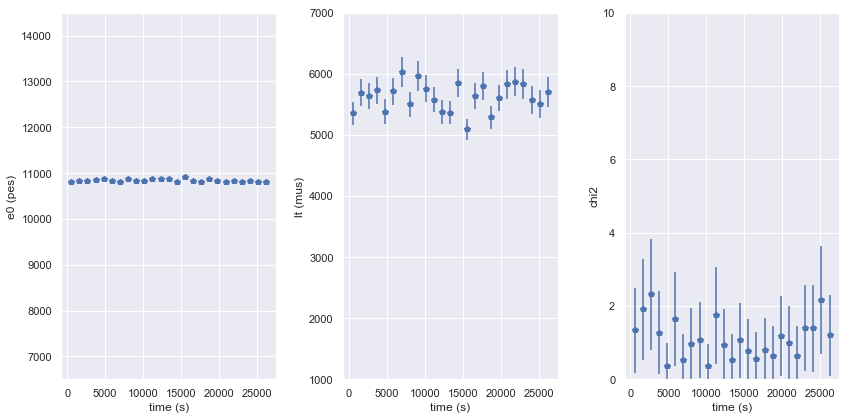

In [43]:
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (6500, 14500),
              range_lt    = lt_range,
              figsize     = (12,6))
# plt.savefig(summary_outputs+'AverageLT.png')

## Lifetime in RPhi

In [44]:
NSECTORS =5  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.
#NSECTORS =4  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
#SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.

In [45]:
from krcal.core.kr_types        import RPhiMapDef

def rphi_sector_map_def_equiareal(nSectors : int   =10,
                                  rmax     : float =200,
                                  sphi     : float =45)->RPhiMapDef:
    """

    Defines the values in (R,Phi) to compute RPHI maps

    Parameters
    ----------
        nSectors:
        Number of radial sectors.

        rmax:
        Maximum radius of map.

        sphi:
        Size of PHI wedge in degrees.

    Returns
    -------
        RPhiMapDef

    @dataclass
    class RPhiMapDef:  # defines the values in (R,Phi) to compute RPHI maps
        r   : Dict[int, Tuple[float, float]] # (rmin, rmax) in each radial sector
        phi : Dict[int, List[Tuple[float, float]]] # (phi_0, ph_1... phi_s) per radial sector

    """

    PHI = {}

    c = 1.0 * rmax / nSectors**0.5
    R = {}
    for ns in range(nSectors):
        ri = c * (ns**0.5)
        rs = c * (ns+1)**0.5
        R[ns] = (ri, rs)

    for ns in range(0, nSectors):
        PHI[ns] = [(i, i+sphi) for i in range(0, 360, sphi)]

    return RPhiMapDef(R, PHI)

rpsmd = rphi_sector_map_def_equiareal(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)


In [46]:
W = define_rphi_sectors(rpsmd)

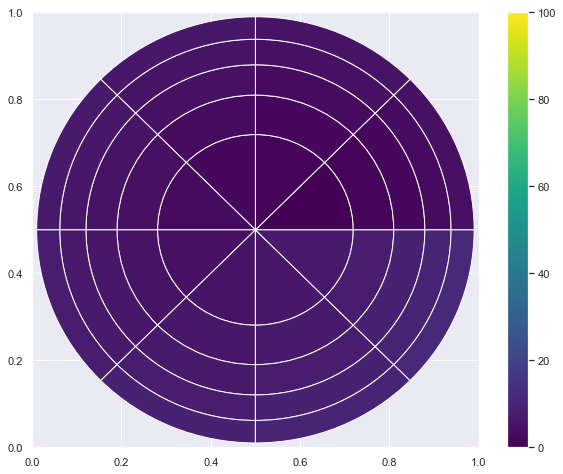

In [47]:
draw_wedges(W,  rmax = RMAX, 
            scale= 0.49, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

In [48]:
t0 = time.time()
#KSRP = select_rphi_sectors(dst, DT, dst.S2e, dst.S2q, W)
KSRP = select_rphi_sectors_df(dst, W) # [edit]
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 0.9005050659179688


In [49]:
neM = event_map_df(KSRP)

In [50]:
neM

,0,1,2,3,4
0,11727,12061,11637,12148,11898
1,11649,11875,12190,12153,12327
2,11168,11446,12307,12118,12060
3,11371,11411,10952,11701,11836
4,11359,11877,10802,10509,11897
5,11428,10521,11490,11010,11477
6,12404,12256,12079,12082,11922
7,11207,12065,11851,11864,12153


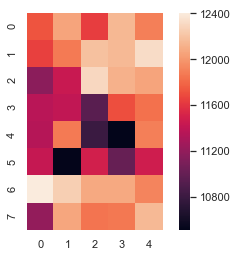

In [51]:
ax = sns.heatmap(neM, square=True)

### four phi sectors: upper half (left-right), lower half (left-right) of chamber

### R < 40 mm

In [52]:
erange = (0,14500)
ltrange = (0, 7000)

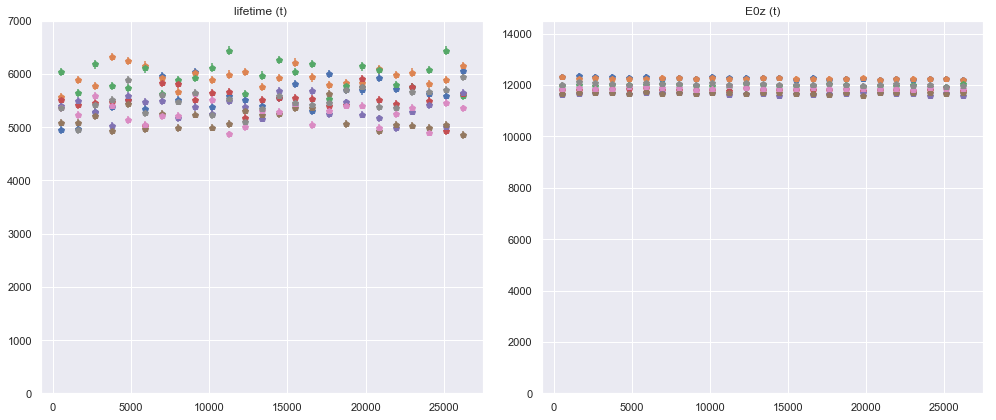

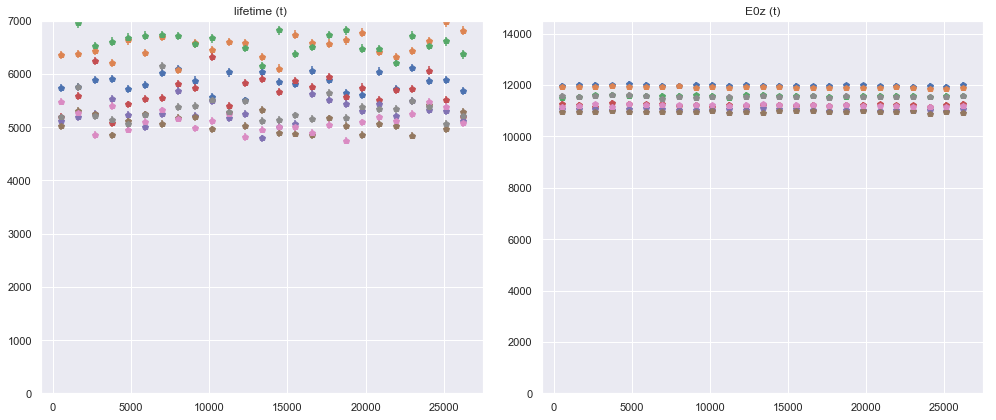

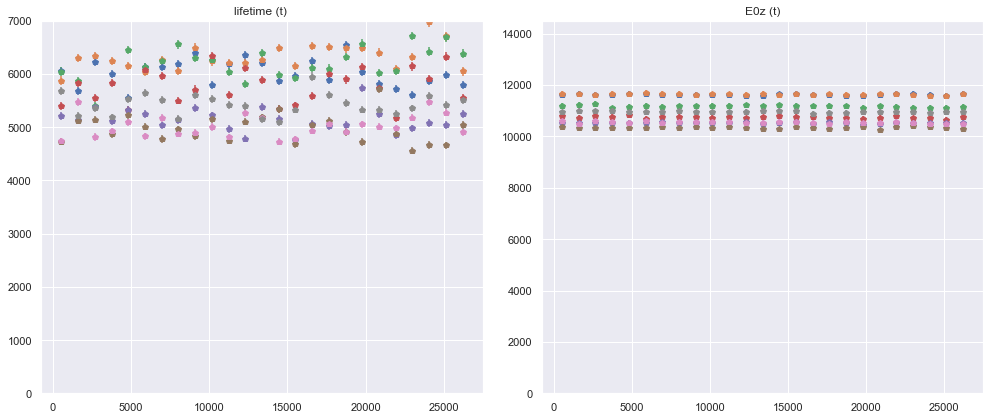

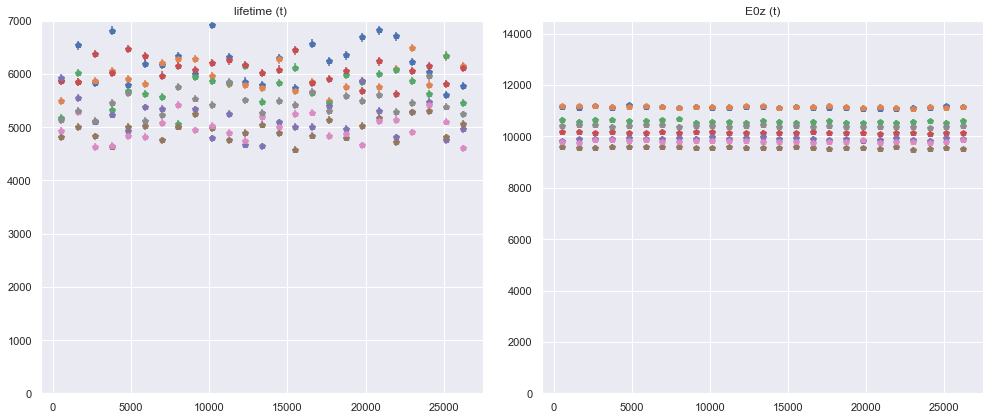

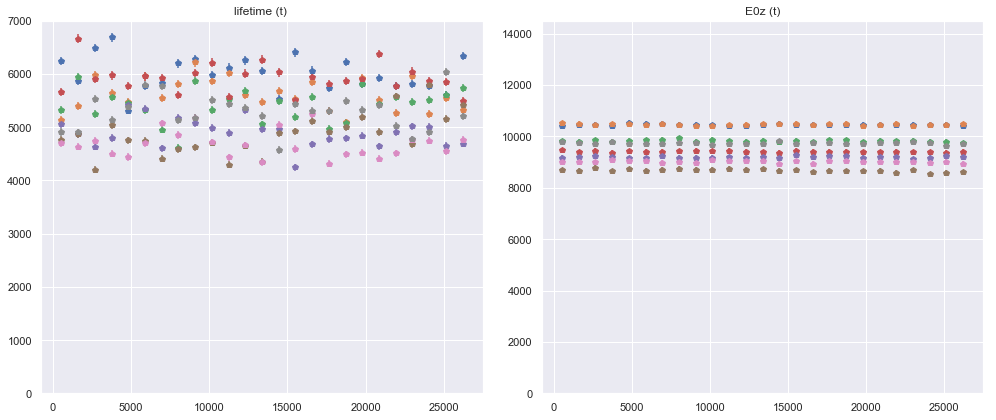

In [53]:
for sector in range(NSECTORS):
    fps_rp = fit_fcs_in_rphi_sectors_df(sector = sector,
                              selection_map = KSRP,
                              event_map     = neM,
                              n_time_bins   = time_bins,
                              time_diffs    = DT,
                              nbins_z       = 25,
                              nbins_e       = 50,
                              range_z       =(50, 550),
                              range_e       = (5000, 14500),
                              energy        = 'S2e',
                              fit           = FitType.unbined,
                              n_min         = 100)
    plot_fit_sectors(fps_rp,  range_e0 =erange, range_lt=ltrange)
    # plt.savefig(summary_outputs+'R_phi_lt'+str(sector+1)+'.png')

### Lifetime patterns:

- Oscillatory pattern in time with a swing of 1 ms!
- Lifetime changes also as a function of Phi, with differences that increase as R increases.
- R > 160 cm data shows very high and very variable lifetime, with a spread of several ms.

### Strategy

- Try to correct geometrical effects first. Fine grained geometrical map with a single time bin.
- Study time dependence later

## Divide chamber in sectors of XY

In [54]:
log.setLevel(logging.DEBUG)

In [55]:
t0 = time.time()
print(len(dst))
print(len(DT))
# KRES = select_xy_sectors(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
KRES_even = select_xy_sectors_df(dst_even, krBins.X, krBins.Y) # [edit]
KRES_odd = select_xy_sectors_df(dst_odd, krBins.X, krBins.Y) # [edit]

t1 = time.time()
print(f' KRES: t = {t1 -t0}')

468288
468288
 KRES: t = 8.085455179214478


In [56]:
log.setLevel(logging.INFO)

In [57]:
neM_even = event_map_df(KRES_even)
neM_odd = event_map_df(KRES_odd)

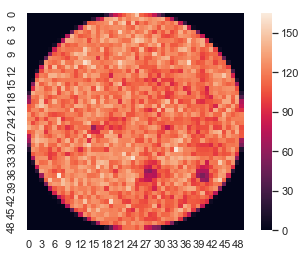

In [58]:
ax = sns.heatmap(neM_odd, square=True)

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```


### Single time bin

In [59]:
t0 = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    fpmxy_even = fit_map_xy_df(selection_map = KRES_even,
                       event_map     = neM_even,
                       n_time_bins   = 1,
                       time_diffs    = DT_even,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy        = 'S2e',
                       fit           = FitType.unbined,
                       n_min         = 100)
    
    fpmxy_odd = fit_map_xy_df(selection_map = KRES_odd,
                       event_map     = neM_odd,
                       n_time_bins   = 1,
                       time_diffs    = DT_odd,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy        = 'S2e',
                       fit           = FitType.unbined,
                       n_min         = 100)

t1 = time.time()
print(f' fpmxy: t = {t1 -t0}')

 fpmxy: t = 25.61437487602234


In [60]:
times_odd = fpmxy_odd[0][0].ts
times_even = fpmxy_even[0][0].ts

In [61]:
times_odd

array([13371.30949998])

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [62]:
tsm_even = tsmap_from_fmap(fpmxy_even)
tsm_odd = tsmap_from_fmap(fpmxy_odd)

### Obtain amap from tsm: The object returned is ASectorMap
```
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : DataFrame
    e0    : DataFrame
    lt    : DataFrame
    e0u   : DataFrame
    ltu   : DataFrame
```
 

#### There is a single time series (ts = 0)

In [63]:
am_odd = amap_from_tsmap(tsm_odd, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)
am_even = amap_from_tsmap(tsm_even, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [64]:
amap_average(am_even)
amap_average(am_odd)

ASectorMap(chi2=1.1554853975836137, e0=10724.413253340199, lt=5564.107519486045, e0u=43.66320374201876, ltu=355.30674802226457, mapinfo=None)

#### Get rid of outlayers that distort mean and error

In [65]:
rmap_even = regularize_maps(am_even, erange=e_range, ltrange=lt_range)
rmap_odd = regularize_maps(am_odd, erange=e_range, ltrange=lt_range)

2019-05-29 10:21:34,225 | INFO :  set nans to average value of interval = 9500.0
2019-05-29 10:21:34,302 | INFO :  set nans to average value of interval = 4000.0
2019-05-29 10:21:34,409 | INFO :  set nans to average value of interval = 9500.0
2019-05-29 10:21:34,477 | INFO :  set nans to average value of interval = 4000.0


In [66]:
amap_average(rmap_even)
amap_average(rmap_odd)

ASectorMap(chi2=1.1554853975836137, e0=10724.413253340199, lt=5484.174028730141, e0u=43.66320374201876, ltu=344.8010130319537, mapinfo=None)

In [67]:
asm_even = relative_errors(rmap_even)
asm_odd = relative_errors(rmap_odd)

In [68]:
amv_even = amap_average(asm_even)
amv_odd = amap_average(asm_odd)

#### Draw the maps using default colormap

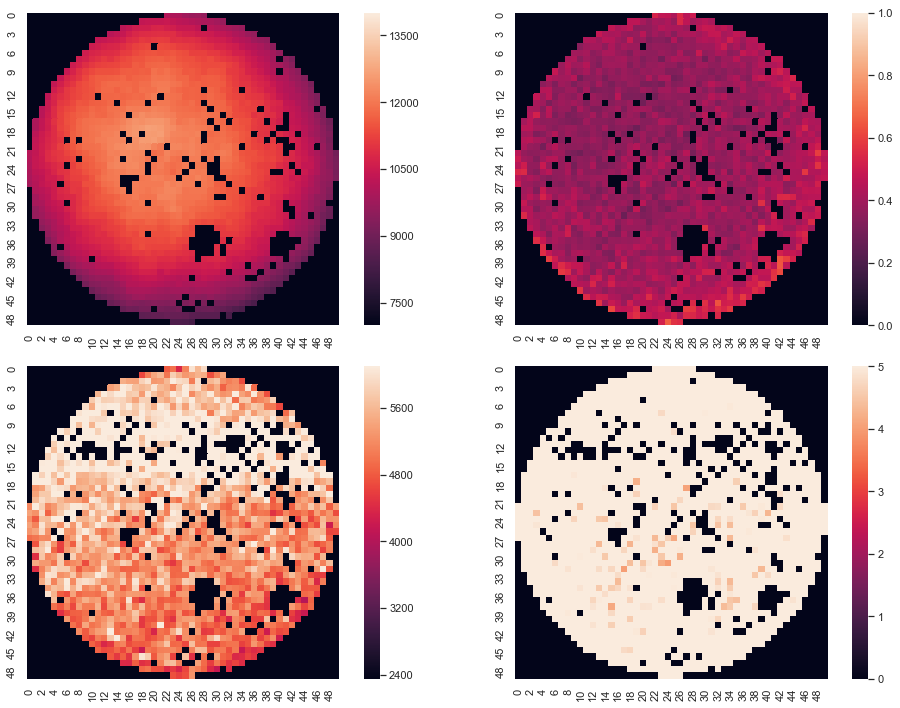

In [69]:
draw_xy_maps(asm_even,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            showPlots = False,
            figsize=(14,10))
# plt.savefig(output_plots+'/lt_e0_xy_maps/lt_e0_xy_'+str(run_number)+'.png')
# plt.savefig(summary_outputs+'maps.png')

In [70]:
asmAv_even = amap_replace_nan_by_mean(asm_even, amMean=amv_even)
asmAv_odd = amap_replace_nan_by_mean(asm_odd, amMean=amv_odd)

In [71]:
amap_avg_list_even=amap_average(asmAv_even)
amap_avg_list_odd=amap_average(asmAv_odd)

'''
text_output = open(output_plots+'/text_outputs/outputs_'+str(run_number)+'.txt','w')

text_output.write('chi2='+str(amap_avg_list.chi2)+'\n')
text_output.write('e0='+str(amap_avg_list.e0)+'\n')
text_output.write('lt='+str(amap_avg_list.lt)+'\n')
text_output.write('e0u='+str(amap_avg_list.e0u)+'\n')
text_output.write('ltu='+str(amap_avg_list.ltu)+'\n')

mean = 0
num = 0

mean_low = 0
mean_high = 0

num_low = 0
num_high = 0

variance = 0
var_low = 0
var_high = 0

stdev = 0
stdev_low = 0
stdev_high = 0

zero_filled = asm.lt.fillna(0)
print(len(zero_filled))
for x in range(len(zero_filled)):
    ymax = len(zero_filled[x])
    for y in range(ymax):
        if (zero_filled[x][y] != 0):
            # get the mean
            mean += zero_filled[x][y]
            num += 1
            # get the means for low and high
            if y < ymax / 2:
                num_high += 1
                mean_high += zero_filled[x][y]
            else:
                num_low += 1
                mean_low += zero_filled[x][y]

mean /= num
mean_low /= num_low
mean_high /= num_high

for x in range(len(zero_filled)):
    ymax = len(zero_filled[x])
    for y in range(ymax):
        if (zero_filled[x][y] != 0):
            variance += (zero_filled[x][y] - mean)**2 / num
            if y < ymax / 2:
                var_high += (zero_filled[x][y] - mean_high)**2 / num_high
            else:
                var_low += (zero_filled[x][y] - mean_low)**2 / num_low
            
stdev = variance**0.5
stdev_low = var_low**0.5
stdev_high = var_high**0.5

mean_diff = (mean_high - mean_low) / mean


text_output.write('lt_mean_diff='+str(mean_diff)+'\n')
text_output.write('lt_mean_low='+str(mean_low)+'\n')
text_output.write('lt_mean_high='+str(mean_high)+'\n')
text_output.write('lt_stdev='+str(stdev)+'\n')
text_output.write('lt_stdev_low='+str(stdev_low)+'\n')
text_output.write('lt_stdev_high='+str(stdev_high)+'\n')

text_output.close()
'''

"\ntext_output = open(output_plots+'/text_outputs/outputs_'+str(run_number)+'.txt','w')\n\ntext_output.write('chi2='+str(amap_avg_list.chi2)+'\n')\ntext_output.write('e0='+str(amap_avg_list.e0)+'\n')\ntext_output.write('lt='+str(amap_avg_list.lt)+'\n')\ntext_output.write('e0u='+str(amap_avg_list.e0u)+'\n')\ntext_output.write('ltu='+str(amap_avg_list.ltu)+'\n')\n\nmean = 0\nnum = 0\n\nmean_low = 0\nmean_high = 0\n\nnum_low = 0\nnum_high = 0\n\nvariance = 0\nvar_low = 0\nvar_high = 0\n\nstdev = 0\nstdev_low = 0\nstdev_high = 0\n\nzero_filled = asm.lt.fillna(0)\nprint(len(zero_filled))\nfor x in range(len(zero_filled)):\n    ymax = len(zero_filled[x])\n    for y in range(ymax):\n        if (zero_filled[x][y] != 0):\n            # get the mean\n            mean += zero_filled[x][y]\n            num += 1\n            # get the means for low and high\n            if y < ymax / 2:\n                num_high += 1\n                mean_high += zero_filled[x][y]\n            else:\n              

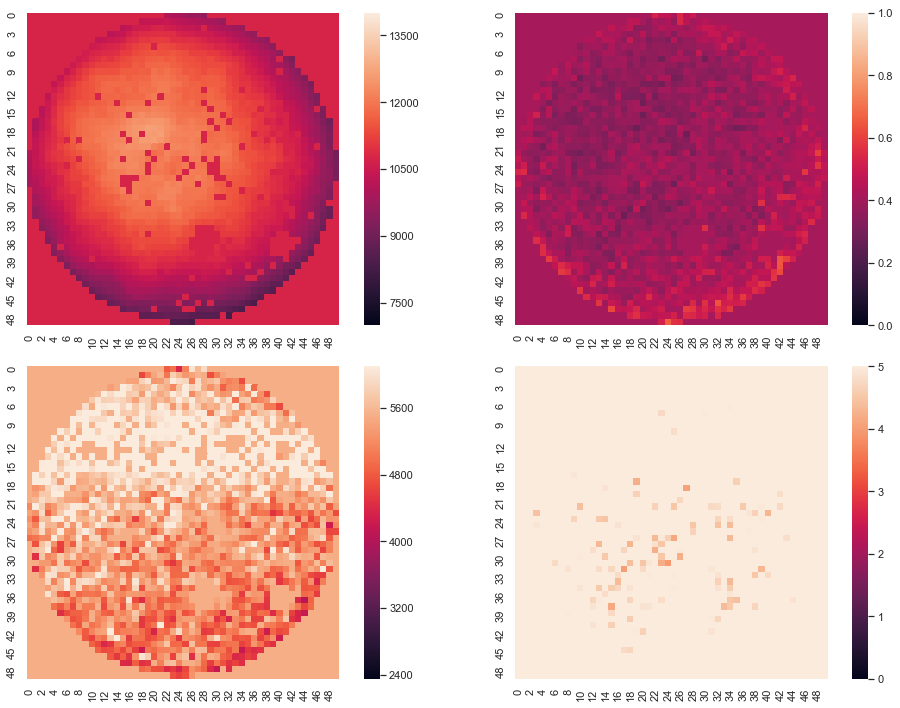

In [72]:
draw_xy_maps(asmAv_even,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [73]:
asm_even = add_mapinfo(asmAv_even, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number)
asm_odd = add_mapinfo(asmAv_odd, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number)

In [74]:
print('The map info is:')
print(asm_even.mapinfo)
write_maps(asm_even, filename=fn.emap_file_name)

The map info is:
xmin          -180
xmax           180
ymin          -180
ymax           180
nx              50
ny              50
run_number    7005
dtype: int64


### Read back

In [75]:
emaps = read_maps(filename=fn.emap_file_name)

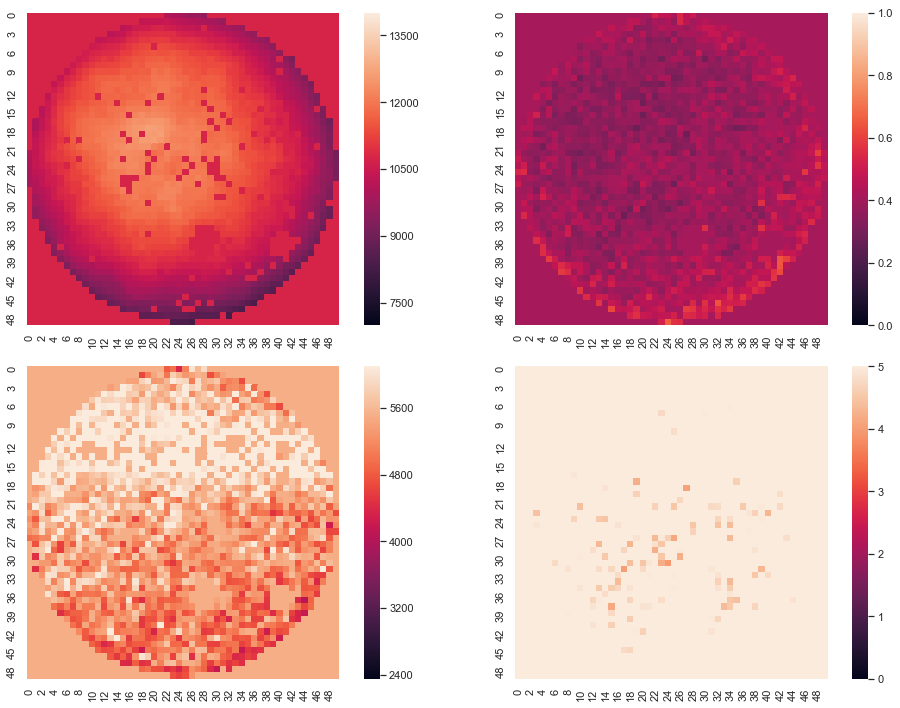

In [76]:
draw_xy_maps(emaps,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize = (14,10))

In [77]:
# # Create x and y indices
# x = np.linspace(0, 200, 201)
# y = np.linspace(0, 200, 201)
# x, y = np.meshgrid(x, y)

# #create data
# initial_guess = (0, 0, 0, 0, 0, 0)
# input_data = (1, 2, 3, 4, 5, 6)
# data = poly((x, y), *input_data)

# # plot twoD_Gaussian data generated above
# plt.figure()
# plt.imshow(data.reshape(201, 201))
# plt.colorbar()

# # add some noise to the data and try to fit the data generated beforehand

# data_noisy = data + 0.2*np.random.normal(size=data.shape)

# popt, pcov = opt.curve_fit(poly, (x, y), data_noisy, p0=initial_guess)

# data_fitted = poly((x, y), *popt)

# # plot
# fig, ax = plt.subplots(1, 1)
# ax.imshow(data_noisy.reshape(201, 201), cmap=plt.cm.jet, origin='bottom',
#     extent=(x.min(), x.max(), y.min(), y.max()))
# ax.contour(x, y, data_fitted.reshape(201, 201), 8, colors='w')
# plt.show()

# print('Guess:')
# print(initial_guess)
# print('Actual data:')
# print(input_data)
# print('Fit parameters:')
# print(popt)

# pct_dev = [100*abs(input_data[i] - popt[i]) / abs(input_data[i]) for i in range(len(input_data))]
# print('Percent errors:')
# print(pct_dev)

In [78]:
def highOrder2DPoly(x_tuple, *p):
    (x, y) = x_tuple
    result = 0*x
    i = 0
    for order in range(maxOrder+1):
        for xpower in range(order+1):
            result = result + p[i] * (x**xpower)*(y**(order - xpower))
            i = i + 1
    return result.ravel()

ORDER =  7


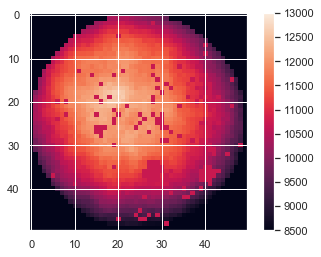

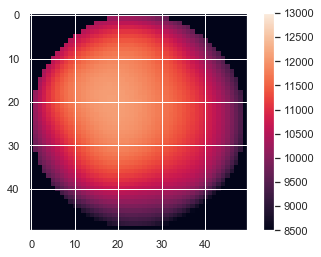

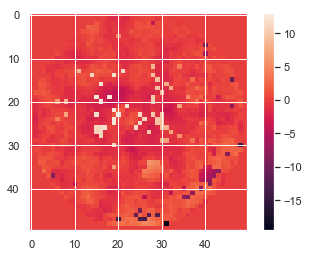

Fit params:
[ 1.07943813e+04 -1.21153223e+03 -4.27818255e+01  1.67871269e+02
  1.98710349e+02 -2.47354412e+01 -9.14716001e+00 -2.03262017e+01
 -9.19124331e+00  3.32767635e+00  2.28535184e-01  9.08129176e-01
  7.51299399e-01  1.87384133e-01 -1.70813391e-01 -2.29457123e-03
 -2.04821826e-02 -2.30649480e-02 -1.44391981e-02 -8.81204641e-04
  4.26298802e-03 -2.43627586e-07  2.14132890e-04  3.51477628e-04
  2.55012627e-04  1.41039885e-04 -1.68272898e-05 -5.35915107e-05
  8.07903233e-08 -6.52064398e-07 -2.44607733e-06 -1.05864724e-06
 -1.74892954e-06 -2.48707019e-07  8.78524482e-08  2.79062277e-07]
Num params:
36
Red X2 =  35.125529916606546
Mean X2 =  34.48151562805859
Fit time =  3.456205129623413


In [79]:
import scipy.optimize as opt
import pylab

# Full chamber
cut = 24.5
c_x = 24.5
c_y = 24.5

maxOrder = 7
numParams = (maxOrder + 1)*(maxOrder + 2)/2

print('ORDER = ', maxOrder)

fit_start = time.time()

def highOrder2DPolyCut(x_tuple, *p):
    (x, y) = x_tuple
    result = 0*x
    i = 0
    for order in range(maxOrder+1):
        for xpower in range(order+1):
            result = result + p[i] * (x**xpower)*(y**(order - xpower))
            i = i + 1
    result = result * ((x-c_x)**2 + (y-c_y)**2 < cut**2)
    return result.ravel()

x = np.linspace(0, 49, 50)
y = np.linspace(0, 49, 50)
x, y = np.meshgrid(x, y)
response = np.array(emaps.e0)

for i in range(len(response)):
    for j in range(len(response[i])):
        if (i - c_x)**2 + (j - c_y)**2 >= cut**2:
            response[i][j] = 0
            
# plot data before fit
pylab.figure()
pylab.imshow(response)
pylab.clim(8500, 13000)
pylab.colorbar()
pylab.show()

initial_guess = tuple(np.arange(numParams)*0)

# Do a full fit, using the restricted fit to seed
popt, pcov = opt.curve_fit(highOrder2DPolyCut, (x, y), response.ravel(), p0=initial_guess)
data_fitted = highOrder2DPolyCut((x, y), *popt)

# plot
pylab.figure()
pylab.imshow(data_fitted.reshape(50, 50))
pylab.clim(8500, 13000)
pylab.colorbar()
pylab.show()

# difference

pct_diff = data_fitted.copy()
ravel_resp = response.ravel()
for i in range(len(pct_diff)):
    if ravel_resp[i] > 0:
        pct_diff[i] = 100*(data_fitted[i] - ravel_resp[i]) / ravel_resp[i]
    else:
        pct_diff[i] = 0

pylab.figure()
pylab.imshow(pct_diff.reshape(50, 50))
pylab.colorbar()
pylab.show()

print('Fit params:')
print(popt)
print('Num params:')
print(len(popt))

# get chi squared
errs = np.array(emaps.e0u).ravel()
RedX2 = 0
nDOF = (3.1415926 / 4) * len(data_fitted) - len(popt)
for i in range(len(data_fitted)):
    if ravel_resp[i] > 0:
        RedX2 += (ravel_resp[i] - data_fitted[i])**2 / (errs[i] * ravel_resp[i] / 100)**2
RedX2perPoint = RedX2 / ((3.1415926 / 4) * len(data_fitted))
RedX2 = RedX2 / nDOF
print('Red X2 = ', RedX2)
print('Mean X2 = ', RedX2perPoint)
print('Fit time = ', time.time()-fit_start)

ORDER =  7


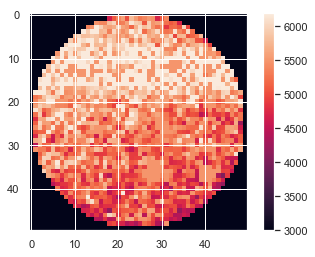

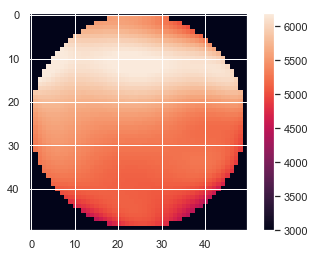

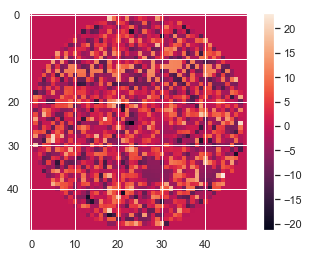

Fit params:
[ 5.53091541e+03  3.75179204e+02 -1.67371433e+02 -2.29052958e+01
 -2.56328858e+01  2.21654378e+01 -1.39964675e+00  5.31567684e+00
 -1.20104701e+00 -9.79747910e-01  1.74312499e-01 -3.05728813e-01
 -7.15942383e-02  1.16573864e-01  1.87625172e-02 -6.60234853e-03
  9.26899579e-03  2.45954825e-03 -3.90093426e-04 -3.25941882e-03
 -2.85246628e-04  1.13063969e-04 -1.52832862e-04 -1.09260709e-05
 -3.62011068e-05  5.09859899e-05  2.72687692e-05  7.55341710e-06
 -7.48200853e-07  1.02238210e-06  1.35629808e-07 -4.69526725e-07
  8.98181792e-07 -1.04547941e-06  1.79458494e-07 -1.07143750e-07]
Num params:
36
Red X2 =  1.35755726133878
Mean X2 =  1.3326669244271405
Fit time =  3.510728120803833


In [80]:
# Smooth lifetime map

# Full chamber
cut = 24.5
c_x = 24.5
c_y = 24.5

maxOrder = 7
numParams = (maxOrder + 1)*(maxOrder + 2)/2

print('ORDER = ', maxOrder)

fit_start = time.time()

x = np.linspace(0, 49, 50)
y = np.linspace(0, 49, 50)
x, y = np.meshgrid(x, y)
response = np.array(emaps.lt)

for i in range(len(response)):
    for j in range(len(response[i])):
        if (i - c_x)**2 + (j - c_y)**2 >= cut**2:
            response[i][j] = 0
            
# plot data before fit
pylab.figure()
pylab.imshow(response)
pylab.clim(3000, 6200)
pylab.colorbar()
pylab.show()

initial_guess = tuple(np.arange(numParams)*0)

# Do a full fit, using the restricted fit to seed
popt, pcov = opt.curve_fit(highOrder2DPolyCut, (x, y), response.ravel(), p0=initial_guess)
data_fitted = highOrder2DPolyCut((x, y), *popt)

# plot
pylab.figure()
pylab.imshow(data_fitted.reshape(50, 50))
pylab.clim(3000, 6200)
pylab.colorbar()
pylab.show()

# difference

pct_diff = data_fitted.copy()
ravel_resp = response.ravel()
for i in range(len(pct_diff)):
    if ravel_resp[i] > 0:
        pct_diff[i] = 100*(data_fitted[i] - ravel_resp[i]) / ravel_resp[i]
    else:
        pct_diff[i] = 0

pylab.figure()
pylab.imshow(pct_diff.reshape(50, 50))
pylab.colorbar()
pylab.show()

print('Fit params:')
print(popt)
print('Num params:')
print(len(popt))

# get chi squared
errs = np.array(emaps.ltu).ravel()
RedX2 = 0
nDOF = (3.1415926 / 4) * len(data_fitted) - len(popt)
for i in range(len(data_fitted)):
    if ravel_resp[i] > 0:
        RedX2 += (ravel_resp[i] - data_fitted[i])**2 / (errs[i] * ravel_resp[i] / 100)**2
RedX2perPoint = RedX2 / ((3.1415926 / 4) * len(data_fitted))
RedX2 = RedX2 / nDOF
print('Red X2 = ', RedX2)
print('Mean X2 = ', RedX2perPoint)
print('Fit time = ', time.time()-fit_start)

In [81]:
amap_average(emaps)

ASectorMap(chi2=1.1426932334769442, e0=10835.631062405191, lt=5515.6861804546825, e0u=0.4058439171645932, ltu=6.207735822972048, mapinfo=None)

In [82]:
norm = amap_max(emaps)

In [83]:
norm

ASectorMap(chi2=18.573137449772325, e0=12638.207727072588, lt=6988.333980801401, e0u=0.6626496502518883, ltu=9.65675282568141, mapinfo=None)

In [84]:
t0 = time.time()
dst = dst_odd
DT = DT_odd
E0 = e0_xy_correction(dst.S2e.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = emaps.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = krNbins.X, 
                      ny  = krNbins.Y)


t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 3.384708881378174


In [85]:
t0 = time.time()
# KRP = select_rphi_sectors(dst, DT, E0, dst.S2q, W)
KRP = select_rphi_sectors_df(dst, W) # [edit]
t1 = time.time()
print(f' KRP: t = {t1 -t0}')

 KRP: t = 0.37893104553222656


In [86]:
neM = event_map_df(KRP)

In [87]:
neM

,0,1,2,3,4
0,5948,5987,5832,6018,5936
1,5798,6040,6118,6128,6183
2,5620,5637,6056,5995,6115
3,5774,5622,5464,5921,5932
4,5730,5893,5347,5319,5989
5,5710,5239,5705,5536,5752
6,6199,6226,5983,6056,5849
7,5537,6006,5966,5928,6050


In [88]:
neM[0]

0    5948
1    5798
2    5620
3    5774
4    5730
5    5710
6    6199
7    5537
Name: 0, dtype: int64

In [89]:
time_write = time.time()

## Select events in region
- r < 180
- 10 < z < 550
- 5000 < E < 14500

In [90]:
rrange = (0, 180)
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)

sel = in_range(dst.R, *rrange) & in_range(dst.Z, *z_range) &  in_range(E, *e_range)
kse = kr_event(dst, DT, E, dst.S2q, sel)  # kse = krypton selected event

Time spent in lt_xy_correction: 4.159985065460205 s


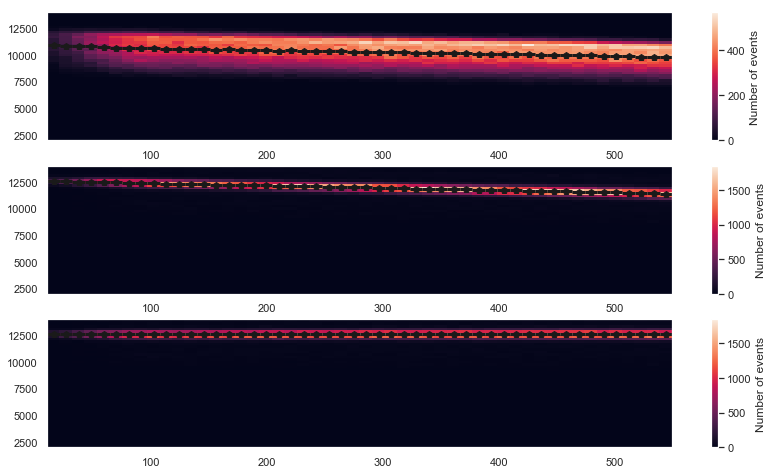

In [91]:
fig = plt.figure(figsize=(14,8))

ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

# plt.savefig(summary_outputs+'CorrectionLT.png')

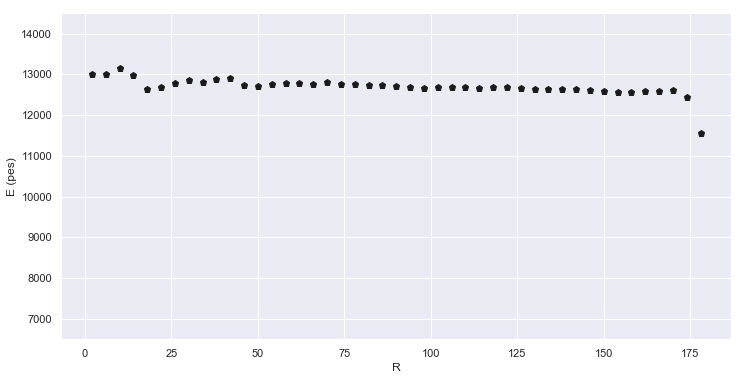

In [92]:
energy_X_profile(dst.R, E, xnbins = num_xy_bins, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14500),  
                 figsize=(12,6))
# plt.savefig(summary_outputs+'RProfile.png')

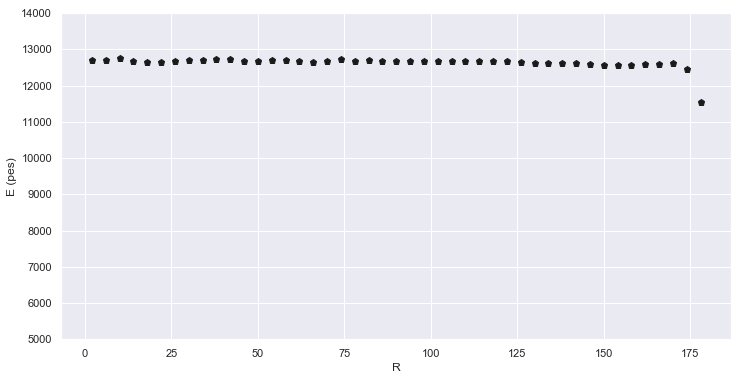

In [93]:
energy_X_profile(kse.R, kse.E, xnbins = num_xy_bins, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))
# plt.savefig(summary_outputs+'RProfileC.png')

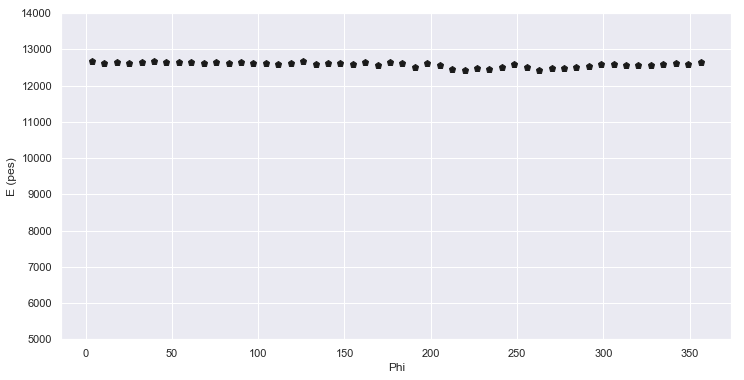

In [94]:
energy_X_profile(phirad_to_deg(kse.Phi), kse.E, xnbins = num_xy_bins, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=e_range,  
                 figsize=(12,6))
# plt.savefig(summary_outputs+'PhiProfile.png')

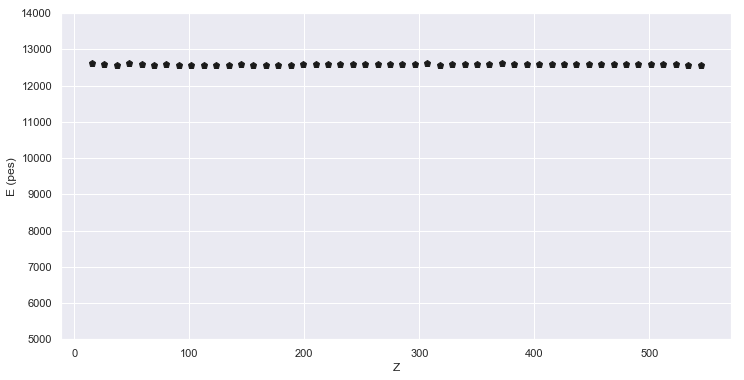

In [95]:
energy_X_profile(kse.Z, kse.E, xnbins = num_xy_bins, xrange=z_range, xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))
# plt.savefig(summary_outputs+'ZProfile.png')

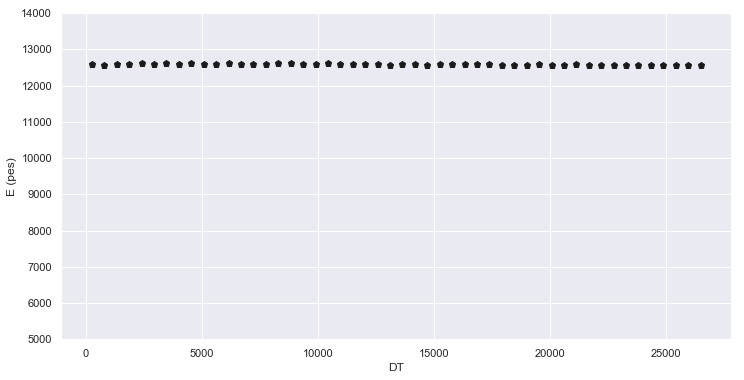

In [96]:
energy_X_profile(kse.DT, kse.E, xnbins = num_xy_bins, xrange=(kse.DT[0], kse.DT[-1]), xlabel = 'DT',
                 erange=e_range,   
                 figsize=(12,6))
# plt.savefig(summary_outputs+'TProfile.png')

/Users/jmhaefner/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


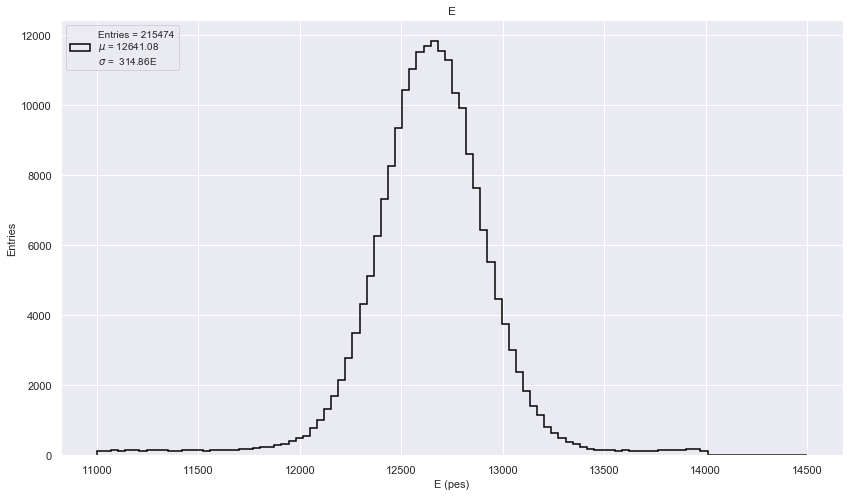

In [97]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 1, 1)

(_)     = h1(kse.E,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 1, 1)

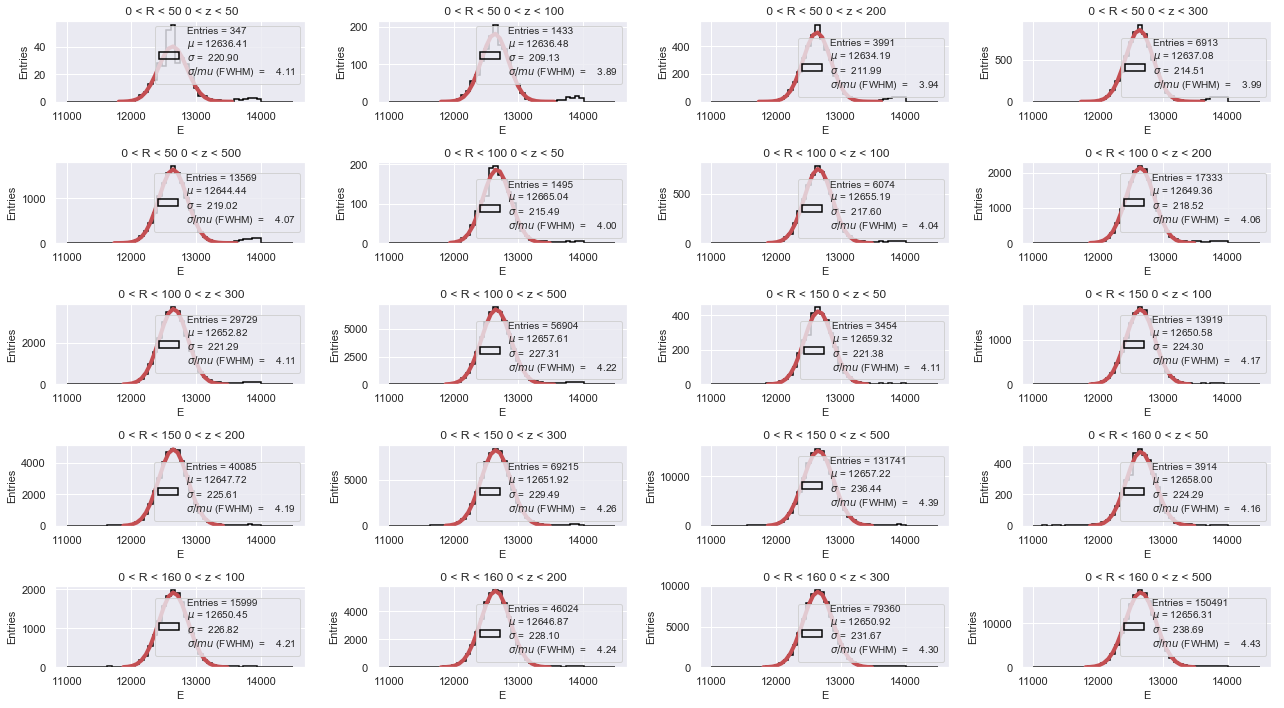

In [98]:
Ri = (50, 100,150,160)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, kse.R, kse.Z, kse.E,
                    enbins = 50,
                    erange = (11e+3, 14500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))
# plt.savefig(summary_outputs+'ResoFit.png')

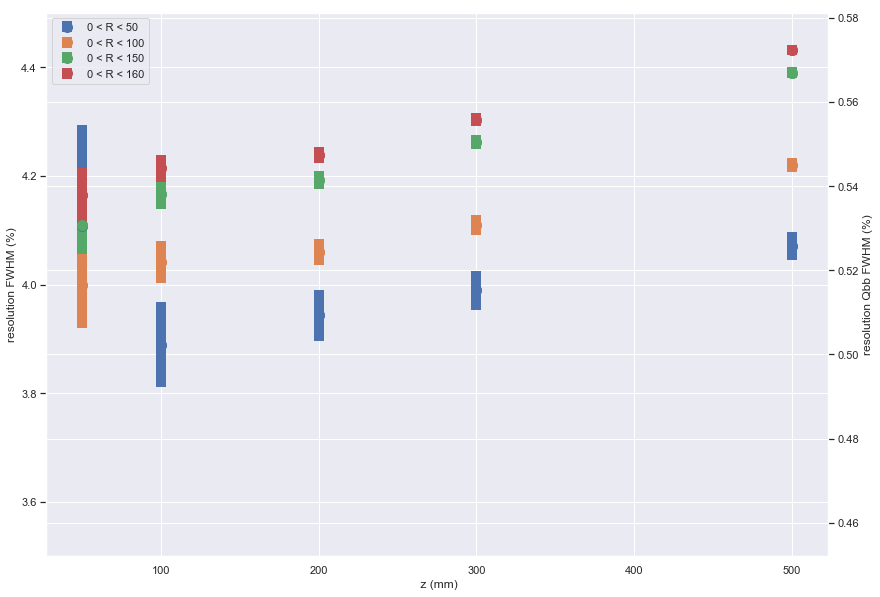

In [99]:
plot_resolution_r_z(Ri, Zi, FC, FCE)

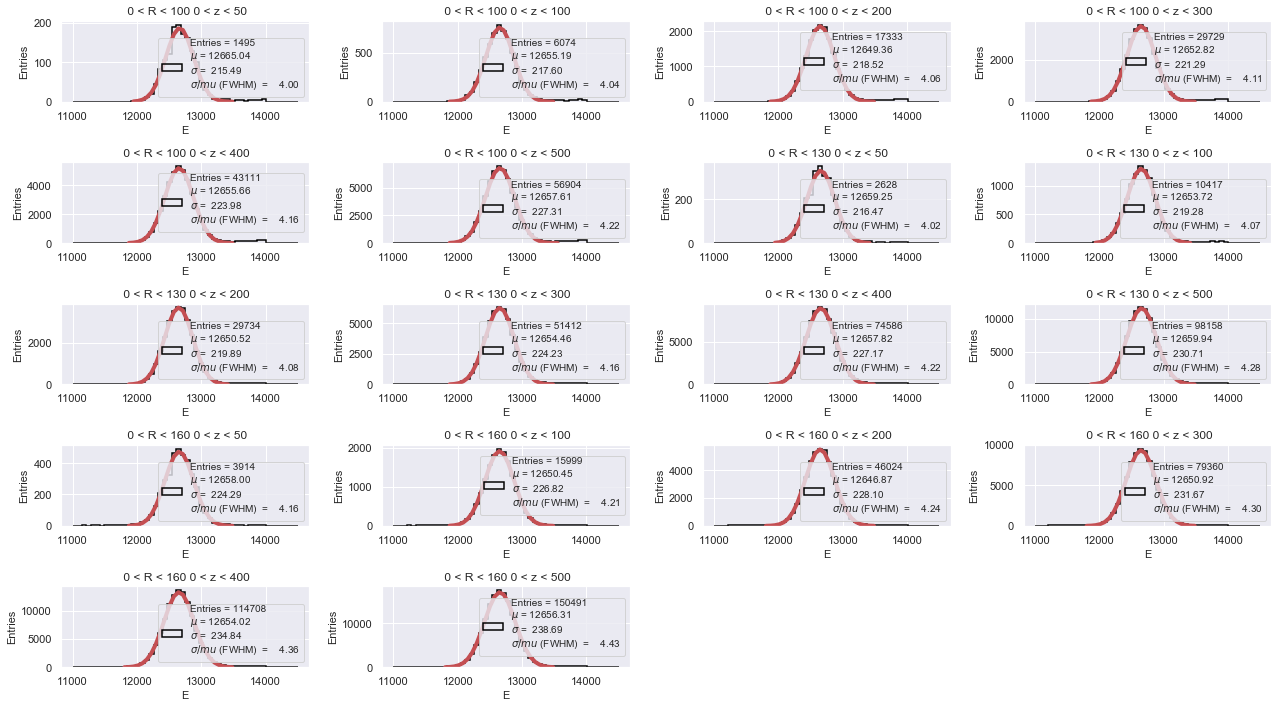

In [100]:
Ri = (100,130,160)
Zi = (50, 100,200,300,400,500)

FC, FCE = resolution_r_z(Ri, Zi, kse.R, kse.Z, kse.E,
                    enbins = 50,
                    erange = (11e+3, 14500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

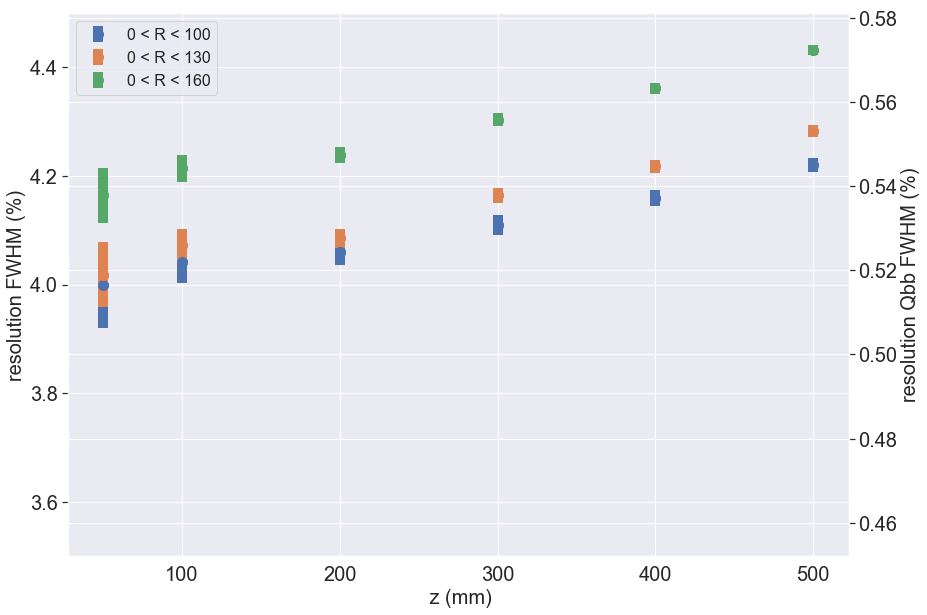

In [125]:
# See https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
plt.rc('axes', titlesize = 20)
plt.rc('axes', labelsize = 20)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

plot_resolution_r_z(Ri, Zi, FC, FCE, showPlots = False)
# plt.savefig(output_plots+'/res_vs_rz/res_vs_rz_'+str(run_number)+'.png')
# plt.savefig(summary_outputs+'ResoVsZR.png')

In [102]:
plot_output_dir = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/ltMaps/plot_parameters/'
plot_outputs = open(plot_output_dir+'plot_outputs_'+str(run_number)+extra_tag+'.txt','w+')

In [103]:
def to_output(mylist, name):
    return name+':'+str(list(mylist))+'\n'

In [104]:
plot_outputs.write(to_output(Ri, 'Ri'))
plot_outputs.write(to_output(Zi, 'Zi'))
plot_outputs.write(to_output(fps.ts, 'fps.ts'))
plot_outputs.write(to_output(fps.e0, 'fps.e0'))
plot_outputs.write(to_output(fps.e0u, 'fps.e0u'))
plot_outputs.write(to_output(fps.lt, 'fps.lt'))
plot_outputs.write(to_output(fps.ltu, 'fps.ltu'))
plot_outputs.write(to_output(fps.c2, 'fps.c2'))
plot_outputs.write(to_output(FC.values.T.tolist(), 'FC'))
plot_outputs.write(to_output(FCE.values.T.tolist(), 'FCE'))
#plot_outputs.write(to_output(kse.R, 'kse.R'))
#plot_outputs.write(to_output(kse.E, 'kse.E'))
#plot_outputs.write(to_output(kse.E, 'kse.Z'))
#plot_outputs.write(to_output(kse.DT, 'kse.DT'))
#plot_outputs.write(to_output(E, 'E'))
#plot_outputs.write(to_output(dst.Z, 'dst.Z'))
#plot_outputs.write(to_output(dst.S2e, 'dst.S2e'))
#plot_outputs.write(to_output(E0, 'E0'))
plot_outputs.close()

In [105]:
param_file = plot_output_dir+'plot_outputs_'+str(run_number)+extra_tag+'.txt'

In [106]:
def list_params(param_file):
    params = []
    plot_params = open(param_file, 'r')
    for line in plot_params.readlines():
        params.append(line[0:line.find(':')])
    plot_params.close()
    return params

In [107]:
print(list_params(param_file))

['Ri', 'Zi', 'fps.ts', 'fps.e0', 'fps.e0u', 'fps.lt', 'fps.ltu', 'fps.c2', 'FC', 'FCE']


In [108]:
def get_param(param, param_file):
    plot_params = open(param_file, 'r')
    for line in plot_params.readlines():
        if param == line[0:line.find(':')]:
            plot_params.close()
            return(line[line.find(':')+1:len(line)-1])

In [109]:
print(get_param('Ri', param_file))

[100, 130, 160]


# R Phi Resolution

In [110]:
print('Number of R sectors =', len(W))
print('Number of phi sectors =', len(W[0]))
print('Example sector =')
print(W[0][0])

Number of R sectors = 5
Number of phi sectors = 8
Example sector =
KrSector(rmin=0.0, rmax=80.49844718999242, phimin=0, phimax=45)


In [111]:
Rj = tuple([W[i][0].rmax for i in range(len(W))])
Rj

(80.49844718999242,
 113.84199576606164,
 139.427400463467,
 160.99689437998484,
 179.99999999999997)

In [112]:
Pj = tuple([W[0][i].phimax for i in range(len(W[0]))])
Pj

(45, 90, 135, 180, 225, 270, 315, 360)

In [113]:
print(len(kse.Phi))
print(min(kse.Phi))
print(max(kse.Phi))
kseDeg = [phi * 180 / 3.1415926535 for phi in kse.Phi]
for i, p in enumerate(kseDeg):
    if p < 0:
        kseDeg[i] += 360
kseDeg = np.array(kseDeg)
print(min(kseDeg))
print(max(kseDeg))
print(len(kseDeg))

215474
-3.1415461693390725
3.1415425582310124
0.00033081430787591554
359.99630467443757
215474


In [114]:
# Exactly the same as the r z version, but goes from (r-1, r) rather than (0, r)

from pandas import DataFrame
from krcal.core.fit_energy_functions import resolution_selected_r_z

def resolution_r_phi(Ri : Iterable[float],
                     Zi : Iterable[float],
                     R : np.array,
                     Z : np.array,
                     E : np.array,
                     enbins = 25,
                     erange = (10e+3, 12500),
                     ixy = (3,4),
                     fdraw = True,
                     fprint = True,
                     figsize = (14,10))->Tuple[DataFrame, DataFrame]:
    if fdraw:
        fig       = plt.figure(figsize=figsize)
    FC = {}
    FCE = {}
    FCE = {}
    j=0
    ix = ixy[0]
    iy = ixy[1]
    for i, r in enumerate(Ri):
        ZR = []
        ZRE = []
        for j, z in enumerate(Zi):
            if i == 0:
                minR = 0
            else:
                minR = Ri[i-1]
            
            if j == 0:
                minZ = 0
            else:
                minZ = Zi[j-1]
            Rr = minR, r
            Zr = minZ, z
            j+=1
            if fdraw:
                ax  = fig.add_subplot(ix, iy, j)
            fc = resolution_selected_r_z(Rr, Zr, R, Z, E, enbins, erange)
            if fdraw:
                plot_fit_energy(fc)
                plot_histo(PlotLabels('E','Entries',f' 0 < R < {r} 0 < z < {z}'), ax, legend= True,
                        legendsize=10, legendloc='best', labelsize=11)
            if fprint:
                print(f'0 < R < {r} 0 < z < {z}')
                print_fit_energy(fc)

            par     = fc.fr.par
            err     = fc.fr.err
            fwhm    = 2.35 * 100 *  par[2] / par[1]
            a       = 2.35 * 100 *  par[2]
            b       = par[1]
            sigma_a = 2.35 * 100 * err[2]
            sigma_b = err[1]

            rer = relative_error_ratio(a, sigma_a, b, sigma_b)
            ZR.append(fwhm)
            ZRE.append(rer*fwhm)
        FC[i] = ZR
        FCE[i] = ZRE

    plt.tight_layout()
    return pd.DataFrame.from_dict(FC), pd.DataFrame.from_dict(FCE)

In [115]:
def plot_resolution_r_phi(Ri : Iterable[float],
                          Zi : Iterable[float],
                          FC : DataFrame,
                          FCE : DataFrame,
                          r_range: Tuple[float,float] = (3.5, 4.5),
                          showPlots : bool = True, # [edit]
                          figsize = (14,10),
                          overwritePhi = ' Phi start (deg)'):

    def extrapolate_to_qbb(es : float)->float:
        return np.sqrt(41 / 2458) * es

    def np_extrapolate_to_qbb(es : np.array)->np.array:
        return np.sqrt(41 / 2458) * es



    fig       = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    Zcenters =np.array(list(Zi))
    for i in FC.columns:
        if i == 0:
            label = f'0 < R < {Ri[i]:2.0f}'
        else:
            label = f'{Ri[i-1]:2.0f} < R < {Ri[i]:2.0f}'

        es = FC[i].values
        eus = FCE[i].values
        qes = extrapolate_to_qbb(es)
        qeus = extrapolate_to_qbb(eus)
        ax.errorbar(Zcenters, es, eus,
                    label = label,
                    fmt='o', markersize=10., elinewidth=10.)
        ax2.errorbar(Zcenters, qes, qeus,
                    label = label,
                    fmt='o', markersize=10., elinewidth=10.)
    plt.grid(True)
    # ax.set_ylim(r_range)
    # ax2.set_ylim(np_extrapolate_to_qbb(np.array(r_range)))

    ax.set_xlabel(overwritePhi)
    ax.set_ylabel('resolution FWHM (%)')
    ax2.set_ylabel('resolution Qbb FWHM (%)')

    plt.legend()

    if showPlots: # [edit]
        plt.show() # [edit]

In [116]:
def removeStochastic(FC, FCE):
    stochasticGuess = 3.7
    FC_sys = FC.copy()
    FCE_sys = FCE.copy()

    for i in range(len(FC.count())):
        for j in range(len(FC[i])):
            FC_sys[i][j] = max(FC[i][j]**2 - stochasticGuess**2, 0)**0.5
            FCE_sys[i][j] = 0
   
    return FC_sys, FCE_sys

 fit failed for seed  = GaussPar(mu=Measurement(value=12715.016262324827, uncertainty=14.252579594859034), std=Measurement(value=311.93293514252775, uncertainty=10.088632114206959), amp=Measurement(value=42.88272623648433, uncertainty=25.28845050982149)), due to RunTimeWarning, retry fit 


<Figure size 432x288 with 0 Axes>

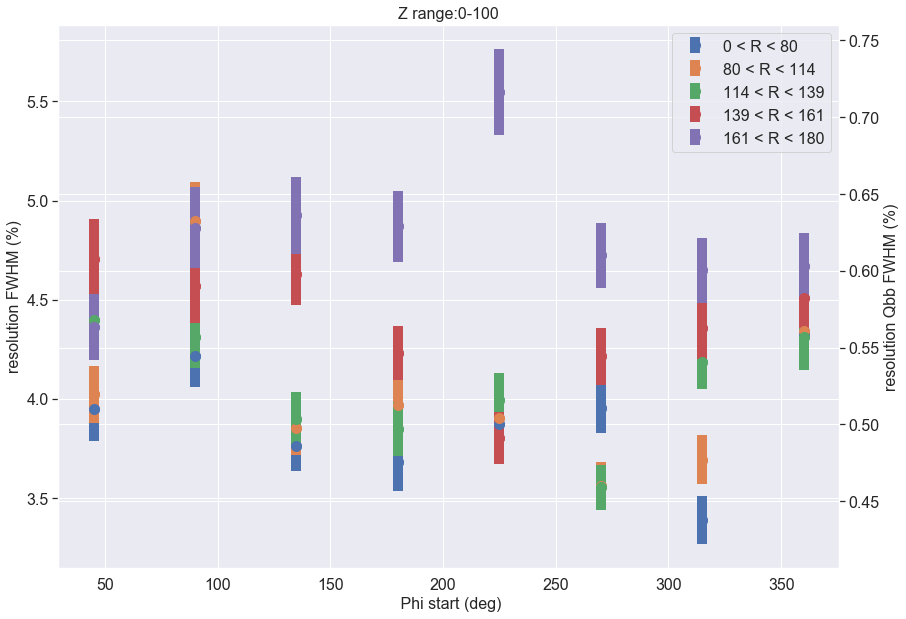

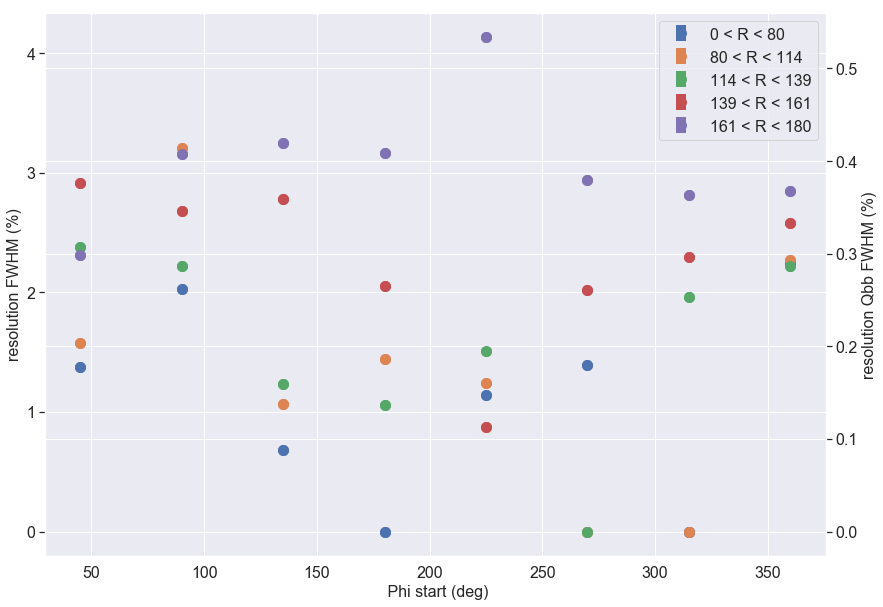

<Figure size 432x288 with 0 Axes>

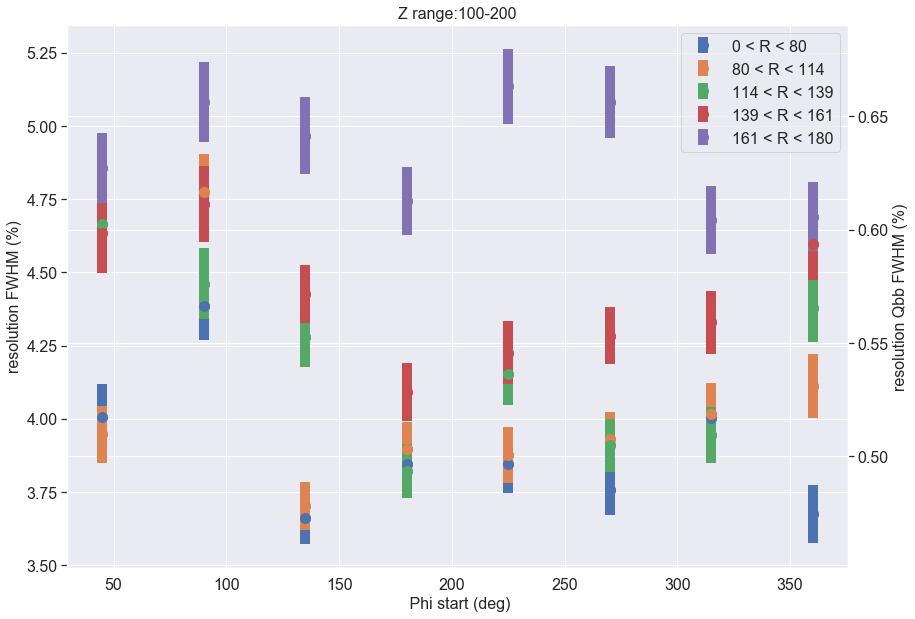

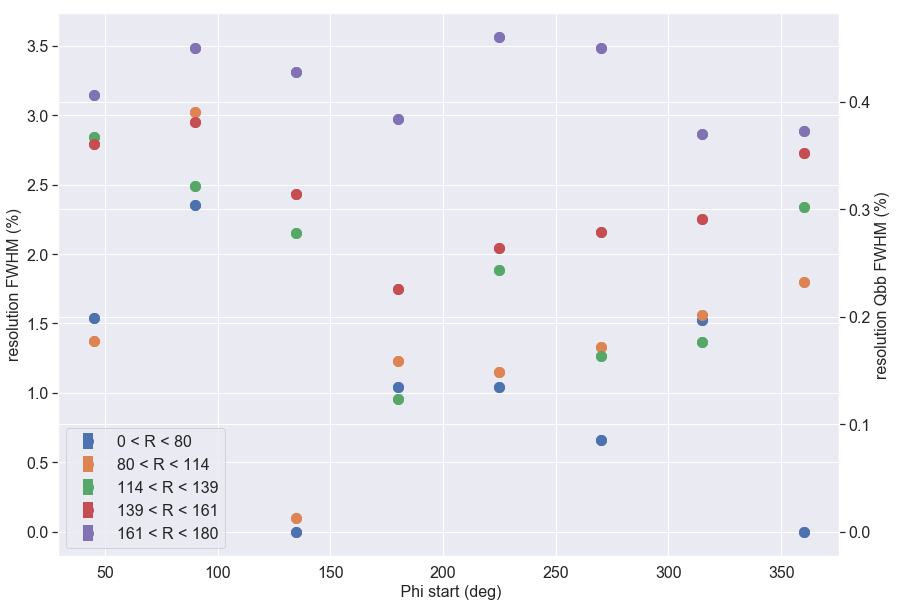

<Figure size 432x288 with 0 Axes>

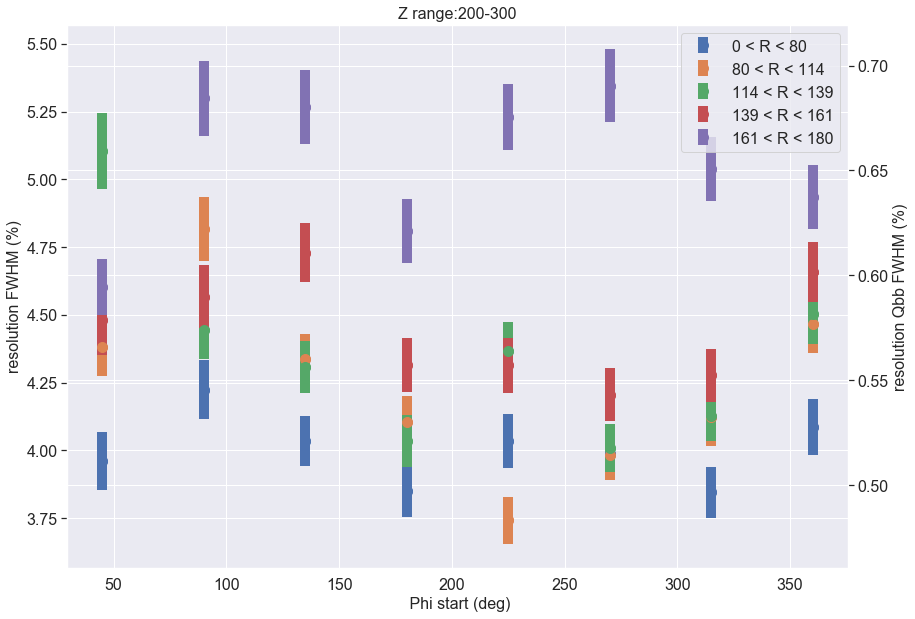

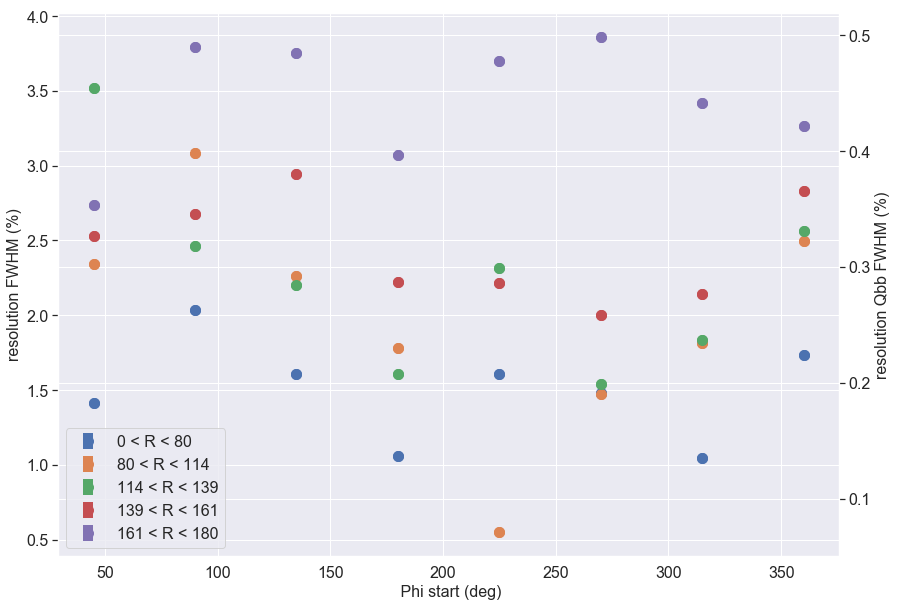

<Figure size 432x288 with 0 Axes>

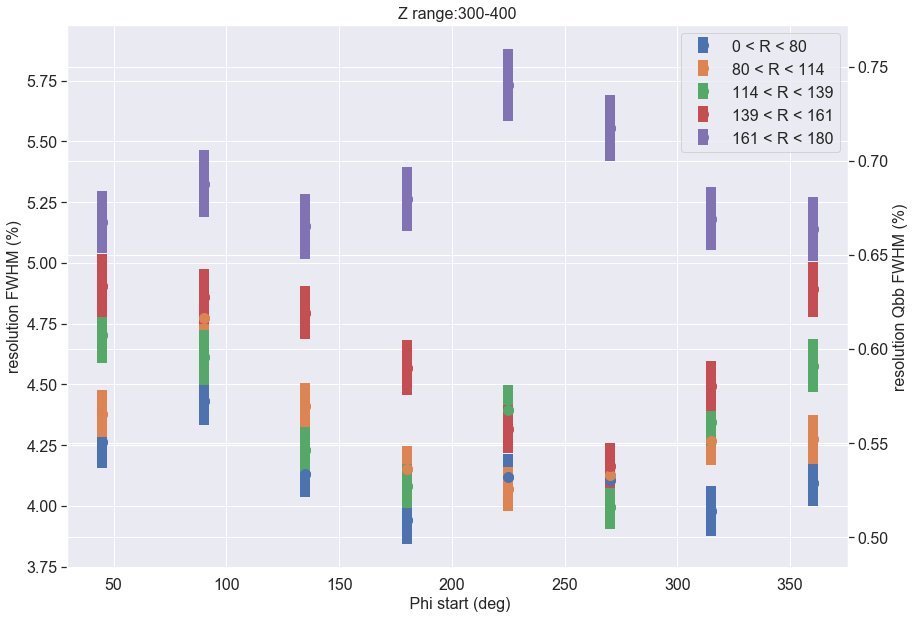

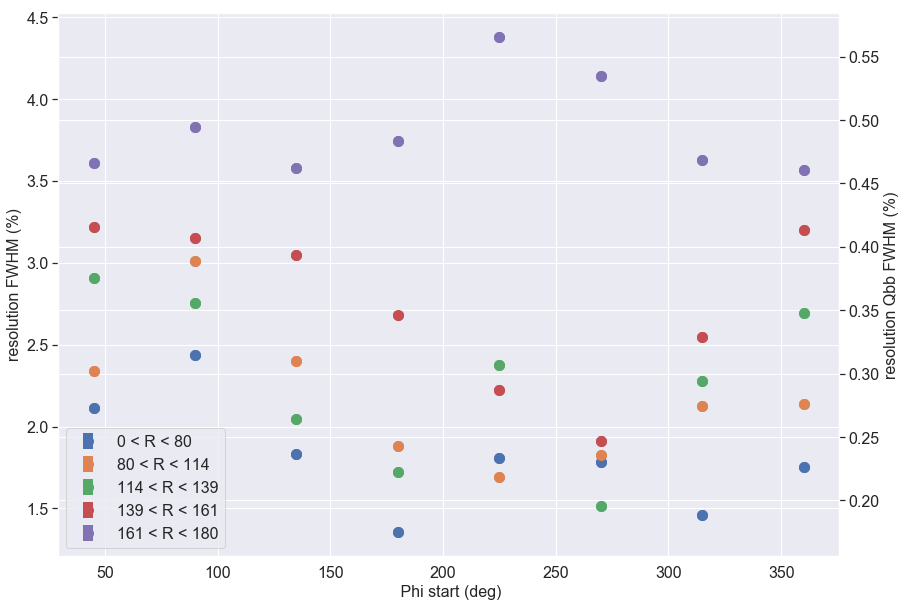

<Figure size 432x288 with 0 Axes>

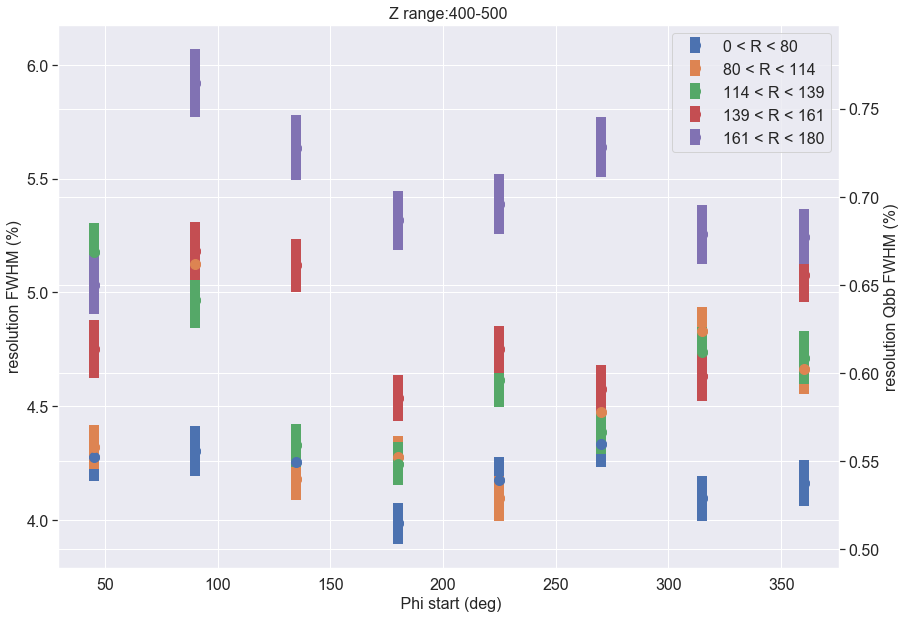

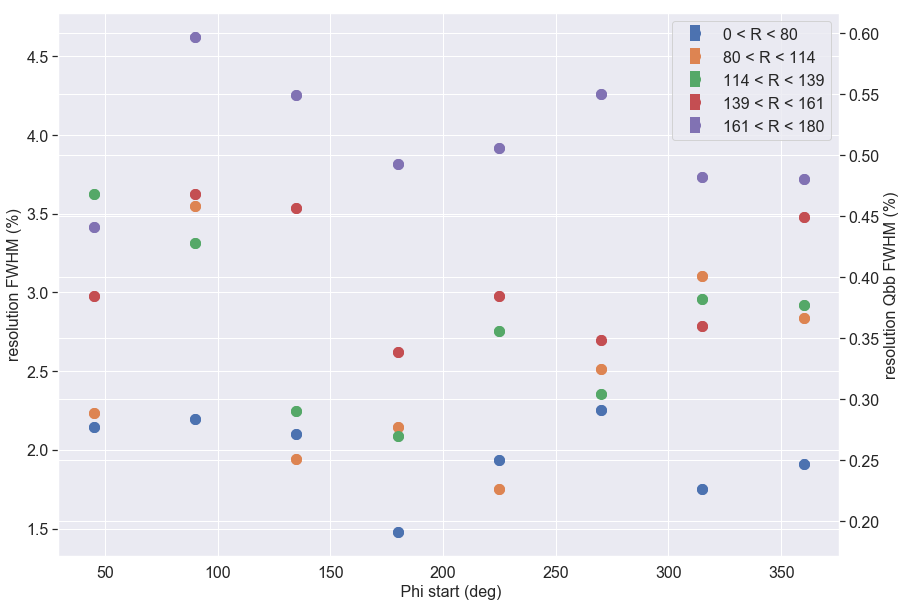

In [117]:
from krcal.core.stat_functions       import relative_error_ratio

Zj = (100, 200, 300, 400, 500)

FCrpVz = []
FCErpVz = []

for i, zmax in enumerate(Zj):

    if i == 0:
        zmin = 0
    else:
        zmin = Zj[i-1]
    
    kseRatZ = []
    kseDegAtZ = []
    kseEatZ = []
    
    for j, z in enumerate(kse.Z):
        if zmin <= z < zmax:
            kseRatZ.append(kse.R[j])
            kseDegAtZ.append(kseDeg[j])
            kseEatZ.append(kse.E[j])

    kseRatZ = np.array(kseRatZ)
    kseDegAtZ = np.array(kseDegAtZ)
    kseEatZ = np.array(kseEatZ)

    FCrp, FCErp = resolution_r_phi(Rj, Pj, kseRatZ, kseDegAtZ, kseEatZ,
                                   enbins = 50,
                                   erange = (11e+3, 14500),
                                   ixy = (len(Rj),len(Pj)),
                                   fdraw  = False,
                                   fprint = False,
                                   figsize = (9,6))

    plot_resolution_r_phi(Rj, Pj, FCrp, FCErp, r_range = (3.5,5), showPlots = False)
    plt.title('Z range:'+str(zmin)+'-'+str(zmax))
    plt.show()
    
    FCrphi_sys, FCErphi_sys = removeStochastic(FCrp, FCErp)
    plot_resolution_r_phi(Rj, Pj, FCrphi_sys, FCErphi_sys, r_range = (0,3), showPlots = True)
    
    FCrpVz.append(FCrp)
    FCErpVz.append(FCErp)

# Time Resolution

In [118]:
kse.T

array([1.55256281e+09, 1.55256281e+09, 1.55256281e+09, ...,
       1.55258956e+09, 1.55258956e+09, 1.55258956e+09])

In [119]:
test = np.array([1,2,3,4,5,6,7,8,9])
test2 = [x > 4 for x in test]
test[test2]

array([5, 6, 7, 8, 9])

In [120]:
timeBlocks = 20
timeFromStartMin = np.array([(t - kse.T[0]) / 60 for t in kse.T])

dt = timeFromStartMin[-1]/timeBlocks
startTimes = [dt * x for x in range(timeBlocks)]
endTimes = [dt * (x+1) for x in range(timeBlocks)]

Tj = endTimes
print(Tj)

[22.2853125, 44.570625, 66.8559375, 89.14125, 111.4265625, 133.711875, 155.9971875, 178.2825, 200.5678125, 222.853125, 245.1384375, 267.42375, 289.7090625, 311.994375, 334.2796875, 356.565, 378.8503125, 401.135625, 423.4209375, 445.70625]


 fit failed for seed  = GaussPar(mu=Measurement(value=12629.748556582874, uncertainty=19.330226123718223), std=Measurement(value=289.95339185577336, uncertainty=13.699010118750666), amp=Measurement(value=21.766487488064882, uncertainty=34.338326098116596)), due to RunTimeWarning, retry fit 


<Figure size 432x288 with 0 Axes>

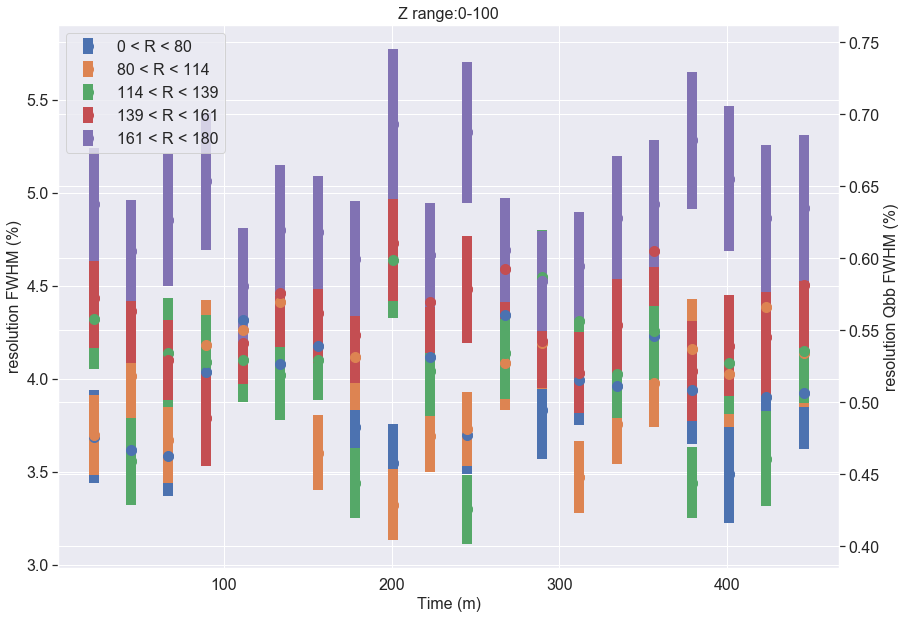

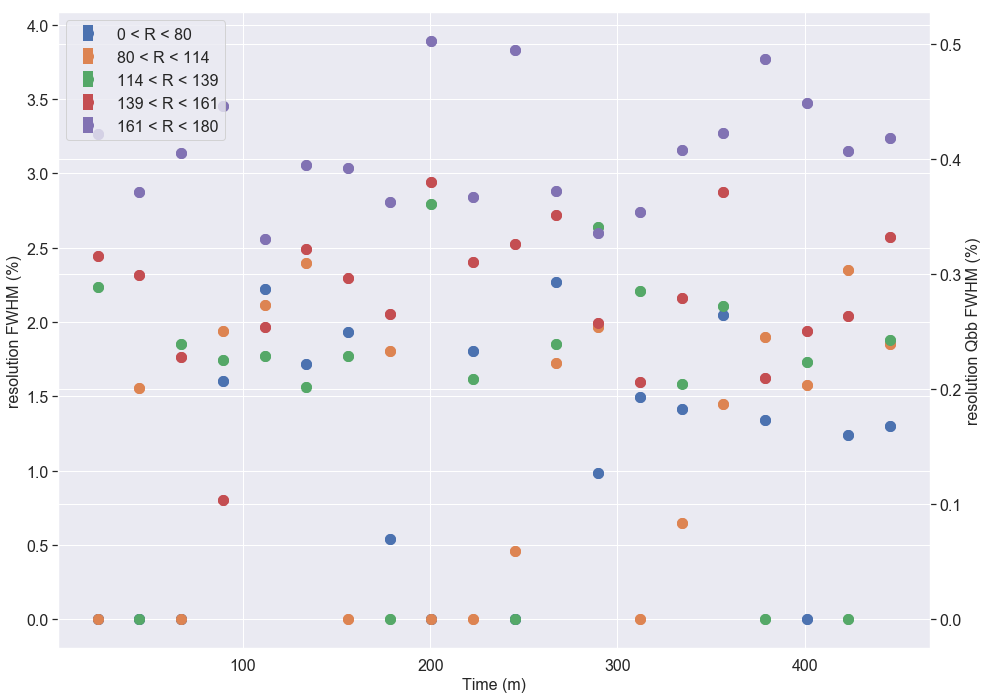

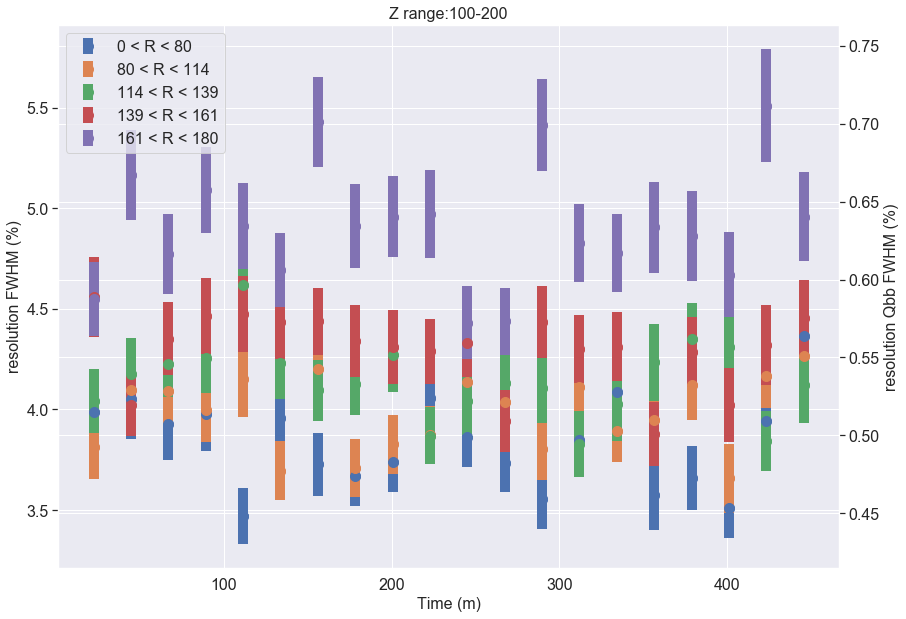

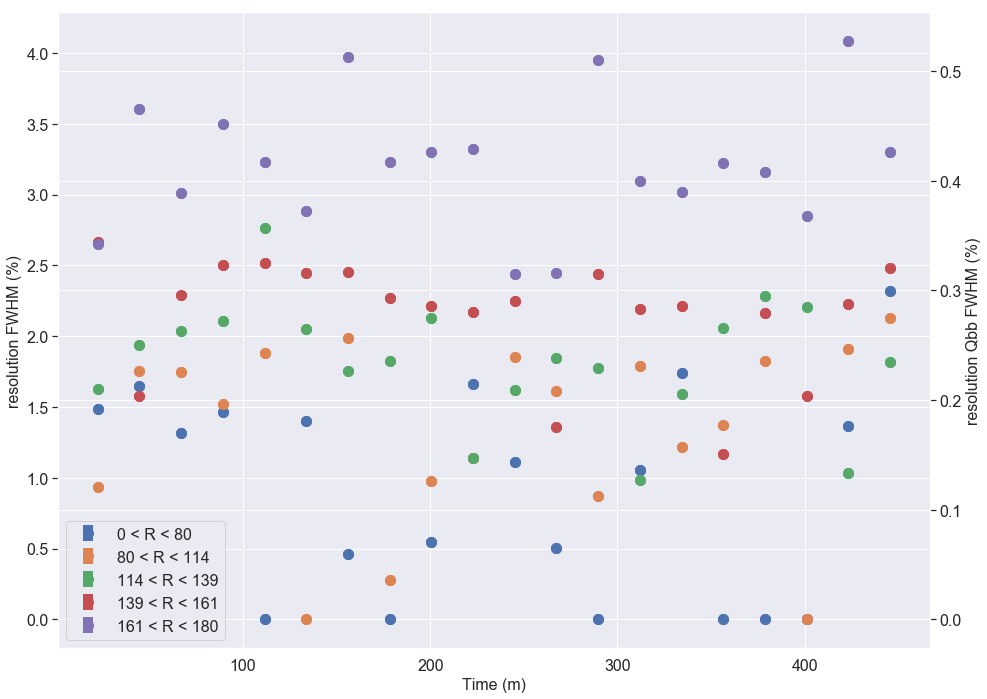

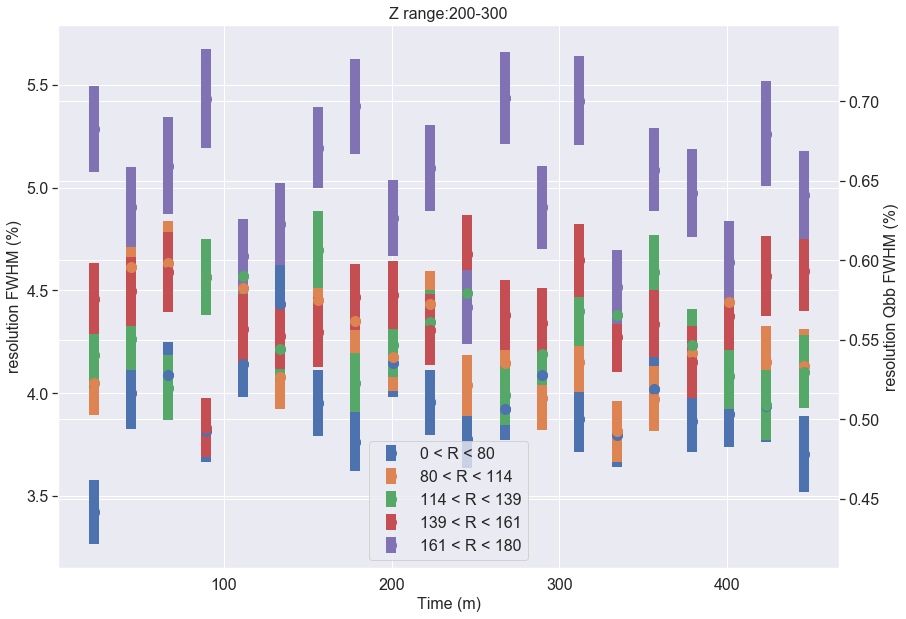

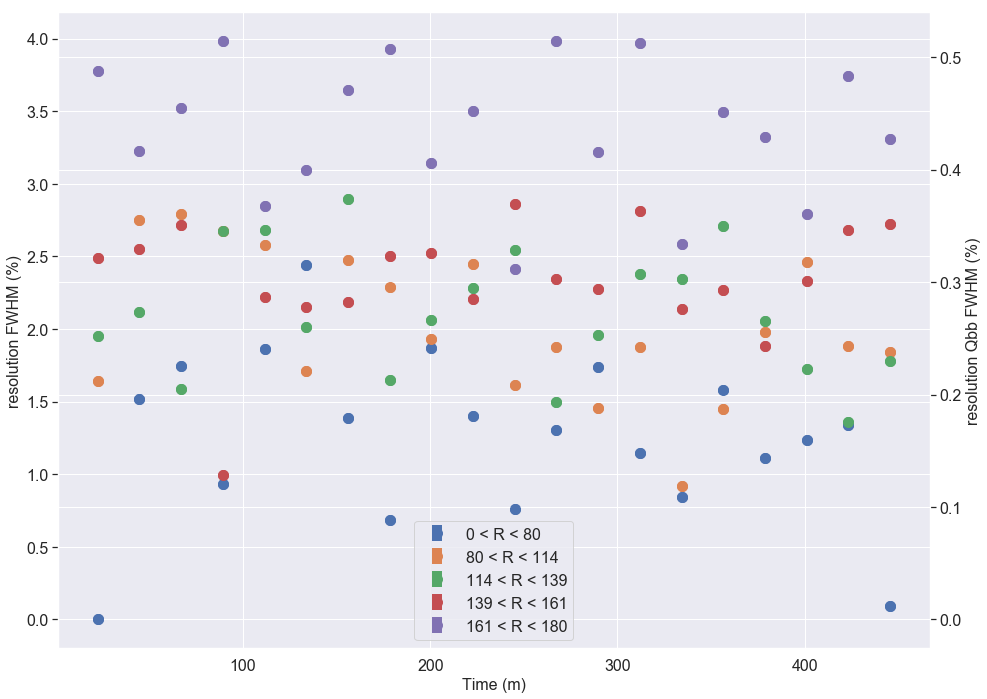

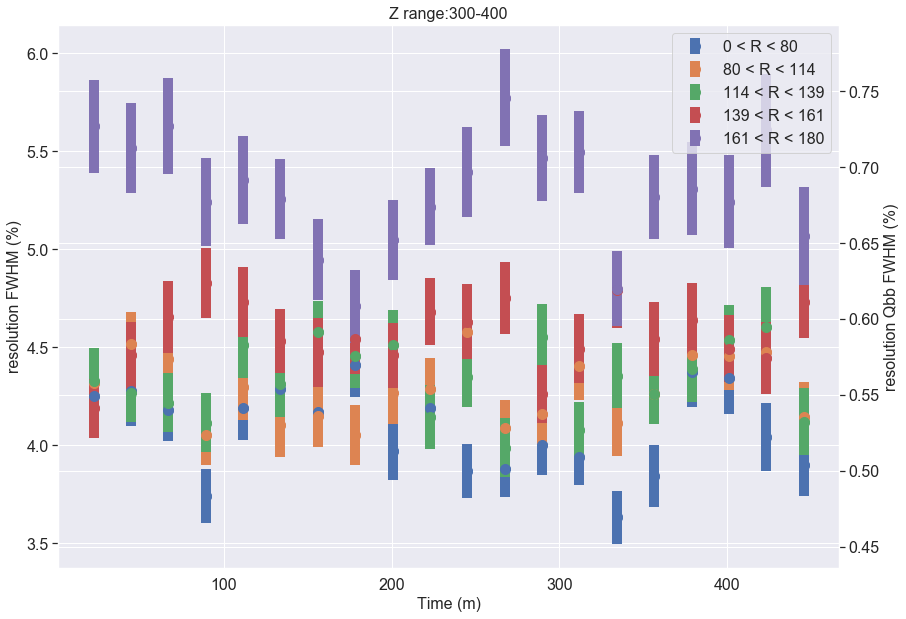

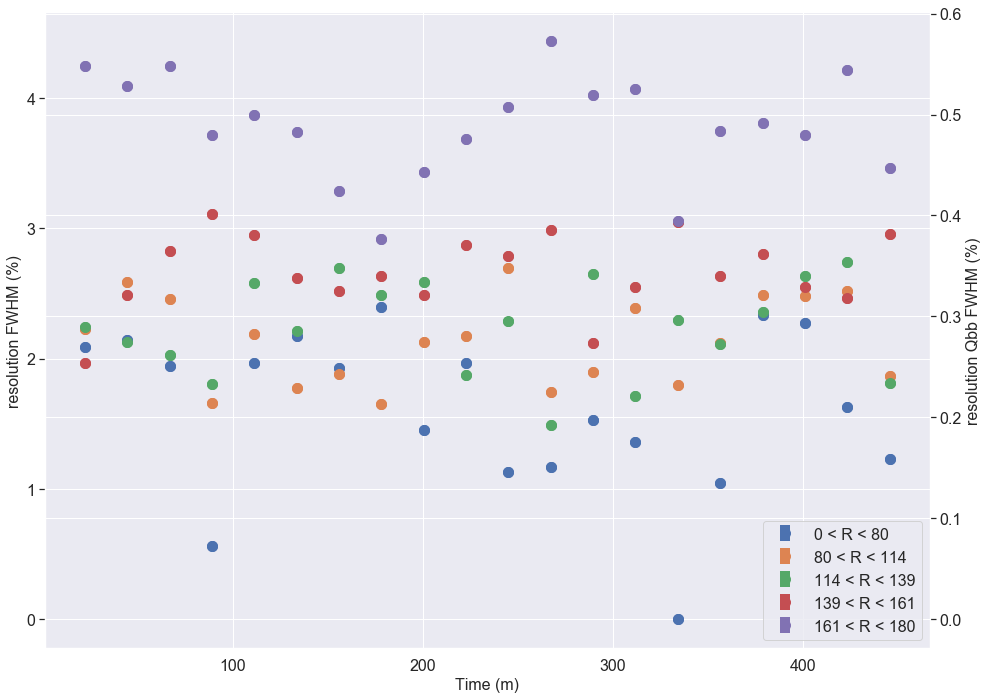

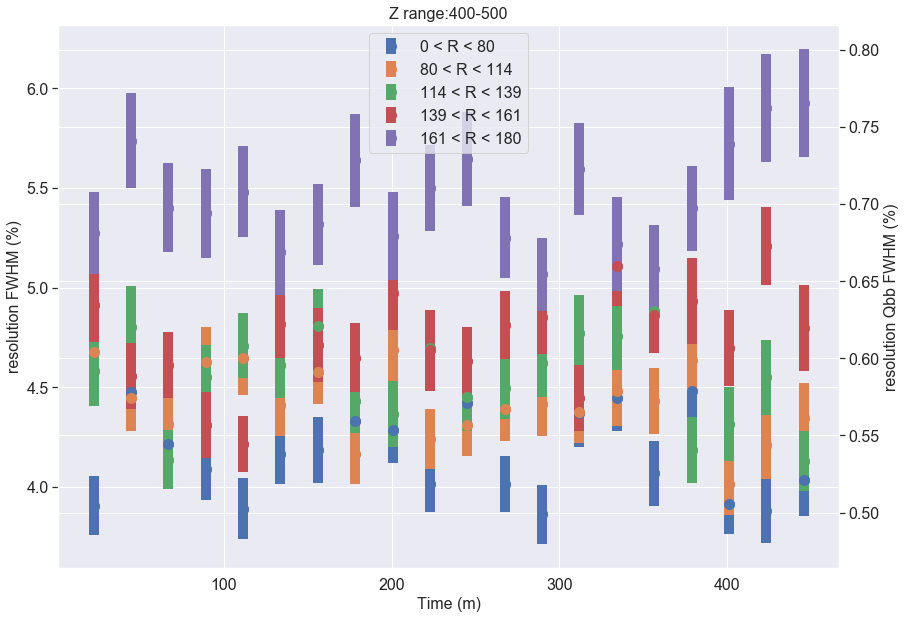

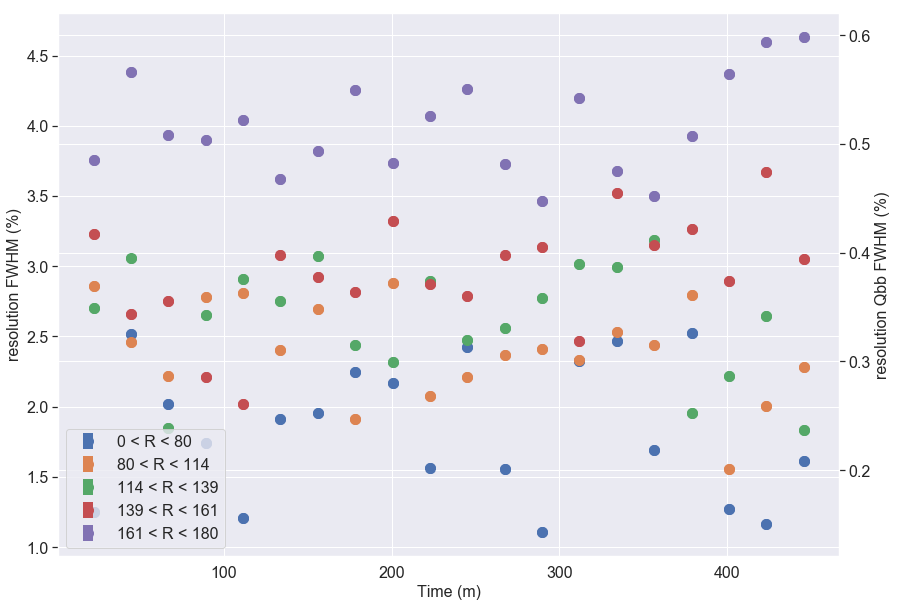

In [121]:
FCtVz = []
FCEtVz = []

for i, zmax in enumerate(Zj):

    if i == 0:
        zmin = 0
    else:
        zmin = Zj[i-1]
    
    kseRatZ = []
    kseTatZ = []
    kseEatZ = []
    
    for j, z in enumerate(kse.Z):
        if zmin <= z < zmax:
            kseRatZ.append(kse.R[j])
            kseTatZ.append(timeFromStartMin[j])
            kseEatZ.append(kse.E[j])

    kseRatZ = np.array(kseRatZ)
    kseTatZ = np.array(kseTatZ)
    kseEatZ = np.array(kseEatZ)

    FCt, FCEt = resolution_r_phi(Rj, Tj, kseRatZ, kseTatZ, kseEatZ,
                             enbins = 50,
                             erange = (11e+3, 14500),
                             ixy = (len(Rj),len(Tj)),
                             fdraw = False,
                             fprint = False,
                             figsize = (18,20))
    
    plot_resolution_r_phi(Rj, Tj, FCt, FCEt, r_range = (3.5,5), showPlots = False, overwritePhi = 'Time (m)')
    plt.title('Z range:'+str(zmin)+'-'+str(zmax))
    plt.show()

    FCt_sys, FCEt_sys = removeStochastic(FCt, FCEt)
    plot_resolution_r_phi(Rj, Tj, FCt_sys, FCEt_sys, r_range = (0,3), showPlots = False, overwritePhi = 'Time (m)')

    FCtVz.append(FCt)
    FCEtVz.append(FCEt)

In [122]:
FCtVzOUT = []
FCEtVzOUT = []
for z in range(len(Zj)):
    v1 = []
    v1e = []
    for r in range(len(Rj)):
        v2 = []
        v2e = []
        for t in range(len(Tj)):
            v2.append(FCtVz[z][r][t])
            v2e.append(FCEtVz[z][r][t])
        v1.append(v2)
        v1e.append(v2e)
    FCtVzOUT.append(v1)
    FCEtVzOUT.append(v1e)

FCrpVzOUT = []
FCErpVzOUT = []
for z in range(len(Zj)):
    v1 = []
    v1e = []
    for r in range(len(Rj)):
        v2 = []
        v2e = []
        for p in range(len(Pj)):
            v2.append(FCrpVz[z][r][p])
            v2e.append(FCErpVz[z][r][p])
        v1.append(v2)
        v1e.append(v2e)
    FCrpVzOUT.append(v1)
    FCErpVzOUT.append(v1e)

In [123]:
outputTitle = './investigation_plot_parameters/'+str(run_number)+'_outputs.txt'
f = open(outputTitle, 'w+')
f.write('Zj='+str(Zj)+'\n')
f.write('Rj='+str(Rj)+'\n')
f.write('Tj='+str(Tj)+'\n')
f.write('Pj='+str(Pj)+'\n')
f.write('FCtVz='+str(FCtVzOUT)+'\n')
f.write('FCEtVz='+str(FCEtVzOUT)+'\n')
f.write('FCrpVz='+str(FCrpVzOUT)+'\n')
f.write('FCErpVz='+str(FCErpVzOUT)+'\n')
f.close()

In [124]:
dt_write = time_write - t_start
dt_plots = time.time() - time_write
print('Time to write =', round(dt_write/60.0,1), 'm')
print('Time to show plots =', round(dt_plots/60.0,1), 'm')

Time to write = 1.4 m
Time to show plots = 0.7 m
